#### Reorganization of BLscale unit test project to be ready for manuscript fig

Adding (a) more animals, (b) more keypoints, (c) more GMM components while
keeping the number of frames low.

### Setup

In [2]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [3]:
from shape_norm.project.paths import Project, create_model
from shape_norm.io import loaders
from shape_norm.models import joint
from shape_norm import config
from shape_norm.models import instantiation, setup, pose, morph, util as model_util
from shape_norm import fitting
from shape_norm.fitting import em
from shape_norm.io import alignment, features
from shape_norm.io.armature import Armature
from shape_norm.fitting import methods
from shape_norm.fitting import scans
from shape_norm.pca import fit_with_center, CenteredPCA, PCAData
from shape_norm.io.dataset import PytreeDataset
from shape_norm.io.dataset_refactor import Dataset, SessionMetadata
from shape_norm.models.morph.lowrank_affine import LRAParams, model as lra_model
from shape_norm import pca
from blscale_loader import loader, linear_skeletal as blscale_ls
import os, sys, shutil
import numpy as np
from pprint import pprint
from matplotlib import colors as mpl_col
import jax.numpy as jnp
import itertools as iit
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
import seaborn as sns
from shape_norm import viz
from shape_norm.viz import styles
from scipy.spatial.distance import jensenshannon
from tensorflow_probability.substrates import jax as tfp
from ruamel.yaml import YAML
from bidict import bidict
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
from cmap import Colormap
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

### KPSN utility functions

In [4]:
# model manipulation
def lra_anchor_poses(params: LRAParams, magnitudes=90):
    """
    Parameters:
    params (LRAParams):
        Parameters used for calculating anchor poses.
    magnitudes (float, numpy.ndarray):
        The magnitude value used in calculating anchor poses. If a float, the
        same magnitude is used for all anchors. If an array, the magnitude
        for each dimension is specified separately. Not applied to the centroid
        anchor.

    Returns, (array, shape (n_bodies, n_dims, n_modes + 1)):
    numpy.ndarray:
        The anchor poses in the canonical pose space.
    """

    L = params.n_dims

    if isinstance(magnitudes, (int, float)):
        magnitudes = magnitudes * np.ones(L)

    # (n_bodies, n_dims, 1)
    anchors = (params.offset + params.offset_updates).reshape(
        params.n_bodies, -1, 1
    )
    # (n_bodies, n_dims, n_modes + 1)
    anchors = np.concatenate(
        [
            anchors,
            anchors
            + magnitudes[None, None] * (params.modes + params.mode_updates),
        ],
        axis=-1,
    )

    return anchors


def anchor_keypoints(
    params: LRAParams,
    align_meta: dict,
    magnitudes=90,
    _inflate=None,
    config=None,
    session_meta: SessionMetadata = None,
):
    """
    Calculate and return the anchor poses from a model in the original keypoint
    space.

    This function computes anchor poses based on the provided parameters and
    alignment metadata, inflates the poses based on a given configuration (if
    any), and then applies inverse alignment scaling to return the poses in
    their original keypoint space.

    Parameters
    ----------
    params, dict:
        Parameters used for calculating anchor poses.
    session_meta, SessionMetadata, optional:
        Session metadata object (accessible via dataset.session_meta) for
        mapping body indices to session indices for rescaling. Required if
        align_meta is provided. If provided, first index of output is over
        session ids, not body ids.
    align_meta, dict:
        Metadata for alignment, optionally including scaling factors under the
        key `scale`.
    magnitudes, int, optional:
        The magnitude value used in calculating anchor poses. Defaults to 90.
    _inflate, function, optional:
        A custom function to inflate anchor poses. If None, a default inflation
        based on the 'features' configuration is used.
    config, dict, optional:
        Configuration dictionary that, if provided, is used to inflate the
        anchor poses using the '_inflate' function. It should contain a
        'features' key if'_inflate' is not provided.

    Returns
    -------
    numpy.ndarray, shape (n_bodies or n_sessions, n_anchor, n_keypt, n_spatial):
        The anchor poses in the original keypoint space after applying inverse
        alignment scaling. If session_meta is provided, the first index is over
        sessions instead of bodies.



    """
    if _inflate is None:
        _inflate = lambda x: features.inflate(x, config["features"])
    anchor_poses = lra_anchor_poses(
        params, magnitudes
    )  # (n_bodies, n_feat, n_anch)
    inflated = _inflate(anchor_poses.transpose(0, 2, 1))
    if session_meta is not None:
        inflated = jnp.array([
            inflated[session_meta.session_body_id(i)]
            for i in range(len(session_meta._session_ids))
        ])
        if "scale" in align_meta:
            inflated = alignment._inverse_align_scales(
                inflated, align_meta["scale"][:, None], stacked=True
            )
    return inflated


def unalign_scales(align_meta, dataset, split_meta = None, base_dataset = None):
    """
    Invert scaling alignment, potentially on a split dataset

    Parameters
    ----------
    align_meta : dict
        The alignment metadata, containing an array under key 'scale' whose
        $i$th element is the scale factor to be applied to sesssion with id $i$.
    dataset : Dataset
        The dataset to invert the scaling on.
    split_meta : tuple, optional
        Tuple whos second element (index 1) maps original session names (in
        `dataset`) to the names of sessions in `dataset`.
    base_dataset : Dataset, optional
        Dataset with session ids that match the indices of
        `align_meta['scale']`. Can be provided if `dataset` is a split dataset
        where alignment was already performed before splitting.
    """
    if base_dataset is not None:
        scan_align_meta = {'scale': np.array([-1. for _ in dataset.sessions])}
        for src_sess, splits in split_meta[1].items():
            for s in splits:
                scan_align_meta['scale'][dataset.session_id(s)] = align_meta['scale'][base_dataset.session_id(src_sess)]
        align_meta = scan_align_meta
    return alignment._inverse_align_scales(dataset, align_meta["scale"]), align_meta



def anchor_magnitudes(
    dataset: Dataset, params: LRAParams, q=0.9, canonicalized=False
):
    """
    Sample the `q`th percentile in absolute value from distributions of anchor
    pose coordinates.

    Parameters
    ----------
    dataset : Dataset or jnp.array
        Feature data, in canonical pose space if `canonicalized` is True. If an
        array, it is assumed to be in canonical pose space.
    model : MorphModel
    params : LRAParams
        Parameters of the model.
    q : float, default 0.9
        The quantile to sample from.
    canonicalized : bool, default False
        Whether the dataset is already in canonical pose space (magnitudes are
        not session- or body-dependent)

    Returns
    -------
    magnitudes : array, shape (n_modes,)
        The selected magnitude in each morph mode.
    """
    if canonicalized:
        canonical = dataset.data
    elif isinstance(dataset, jnp.ndarray):
        canonical = dataset
    else:
        canonical = model_util.apply_bodies(
            lra_model,
            params,
            dataset,
            {
                s: dataset.session_body_name(dataset.ref_session)
                for s in dataset.sessions
            },
        ).data

    coords = canonical @ params.modes  # (n_pts, n_modes)
    qix = jnp.argsort(coords, axis=0)[
        int(coords.shape[0] * q)
    ]  # argquantile
    selected_coord = coords[qix, jnp.arange(coords.shape[1])]
    return selected_coord

### Dataset utility functions

In [23]:
def raw_data_armature_meta():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base','t_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 't_base', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

_with_match = lambda test, pattern, f: f(m) if (m := re.search(pattern, test)) else None
_name_func = lambda path, *a: _with_match(
    path, r"(?:/.*)+/\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy",
    lambda m: f"{m.group(1)}")

def blscale_dataset(source_dict, scale_dict, data_dir, ref_session = None):
    """
    Create a dataset using `blscale_loader`

    Parameters
    ----------
    source_dict : str or Path
        Path to the source dictionary
    scale_dict : str or Path
        Path to the scale dictionary

    Returns
    -------
    project_config_kws : dict
        Keyword args for `loaders.arrays.setup_project_config`
    coords : dict
        Dictionary mapping session names to (unaligned) keypoint data
    scales : dict
        Dictionary mapping session names to scale bone-wise scale factors and
        uniform scale factors.
    """
    session_names = loader.find_sessions(
        sources = source_dict,
        scales = scale_dict,
        ext = '.npy',
        name_func = _name_func,
    )
    session_bodies = {s: f"body-{s}" for s in session_names}

    # skeleton without dropped keypoints
    names, parents, bones, root = raw_data_armature_meta()

    coords, _, _ = loader.external_scale(
        data_dir,
        sources=source_dict,
        scales=scale_dict,
        bones=bones,
        root_keypoint_ix=root,
        ext=".npy",
        name_func=_name_func,
    )
    _, scales = loader._align_scales_sources(
        source_dict, scale_dict, ext=".npy", name_func=_name_func
    )

    ref_session = list(coords.keys())[0]

    project_config_kws = {
        "session_names": list(coords.keys()),
        "bodies": session_bodies,
        "ref_session": ref_session,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, coords, scales

### Plotting utility functions

In [6]:
def getc(spec):
    try:
        from cmap import Colormap, Color
        try:
            return Color(spec)
        except ValueError as e:
            stop = spec.split(':')[-1]
            if stop.startswith('.'):
                stop = float(stop)
            else:
                stop = int(stop)
            cm = Colormap(':'.join(spec.split(':')[:-1]))
            return cm(stop)
    except ImportError:
        return spec

def plot_mouse_3d(
    frame,
    ax,
    armature,
    elev,
    rot,
    colors=None,
    bone_n=40,
    point_size=10,
    line_size=2,
    line_colors=None,
    point_kws={},
    line_kws={},
    boundary=True,
    set_aspect=True,
    label = None
):
    """all keys in point kws should be present in line kws"""

    if colors is None:
        import seaborn as sns

        colors = mpl_col.to_rgba(sns.color_palette("Blues", 10 + frame.shape[0])[10:])
    if line_colors is None:
        line_colors = colors
    colors = np.array([mpl_col.to_rgba(x) for x in colors])
    line_colors = np.array([mpl_col.to_rgba(x) for x in line_colors])
    point_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **point_kws,
    }
    line_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **line_kws,
    }

    # --- points

    x, y, z, c, s = [], [], [], [], []
    x.append(frame[:, 0])
    y.append(frame[:, 1])
    z.append(frame[:, 2])
    c.append(colors)
    s.append([point_size] * armature.n_kpts)
    kws = {k: [] for k in point_kws}
    concat_keys = []
    for k, v in point_kws.items():
        if np.array(v).shape[:1] == (armature.n_kpts,):
            concat_keys.append(k)
            kws[k].append(v)
        else:
            kws[k] = v

    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])
    point_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    # --- "lines"

    x, y, z, c, s = [], [], [], [], []
    kws = {k: [] for k in line_kws}
    concat_keys = []
    for i, (ch, pa) in enumerate(armature.bones):
        x.append(np.linspace(frame[ch, 0], frame[pa, 0], bone_n)[1:-1])
        y.append(np.linspace(frame[ch, 1], frame[pa, 1], bone_n)[1:-1])
        z.append(np.linspace(frame[ch, 2], frame[pa, 2], bone_n)[1:-1])
        c.append(np.full([bone_n - 2, 4], line_colors[ch]))
        s.append(np.full([bone_n - 2], line_size))
        for k, v in line_kws.items():
            if np.array(v).shape[:1] == (armature.n_kpts,):
                concat_keys.append(k)
                kws[k].append(np.full((bone_n - 2,) + np.array(v).shape[1:], v[ch]))
            else:
                kws[k] = v
    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])

    line_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    ax.view_init(elev, rot)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])
    if not boundary:
        ax.xaxis.pane.set_linewidth(0)
        ax.yaxis.pane.set_linewidth(0)
        ax.zaxis.pane.set_linewidth(0)
        ax.xaxis.line.set_linewidth(0)
        ax.yaxis.line.set_linewidth(0)
        ax.zaxis.line.set_linewidth(0)

    
    # use a.set_box_aspect to make the aspect equal to the ratio of the limits
    if set_aspect:
        xrng = np.ptp(ax.get_xlim())
        yrng = np.ptp(ax.get_ylim())
        zrng = np.ptp(ax.get_zlim())
        ax.set_box_aspect([xrng, yrng, zrng])

    return point_artist, line_artist

## One GMM component

### Project and dataset setup

In [6]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "individual" / f"{base}wk_m0-to-52wk.yaml"
scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"

# scale_dict = random_scale_dict('3wk_52bod_m0')

project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')

# make a farse dataset
# dataset_keypoints['3wk_52bod_m0'] = dataset_keypoints['3wk_3bod_m0']

Loading keypoints: 100%|█████████████████| 1/1 [00:00<00:00, 310.46it/s]

Sessions: ['3wk_3bod_m0', '3wk_52bod_m0']


In [7]:
# Create base project config to override

project_dir = Path('../projects/blscale-test/3wk-to-52-pose1')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



### Calibration and training

In [8]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=1000,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["fit"]["n_steps"] = 1000
cfg["fit"]["learning_rate"] = 1e-1
cfg["fit"]["mstep"]["tol"] = None

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=1)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

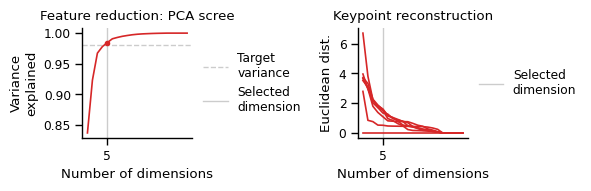

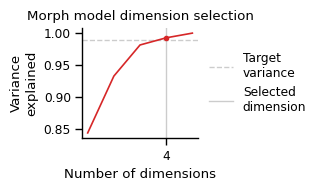

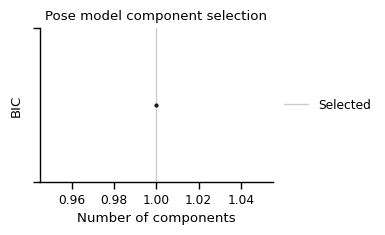

PosixPath('../projects/blscale-test/3wk-to-52-pose1/plots/pose_calibration.pdf')

In [9]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [10]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 3e0, 1e2],
    'fit.em.learning_rate': [1e-1, 1e-2, 1e-2]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [ ]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20)

### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


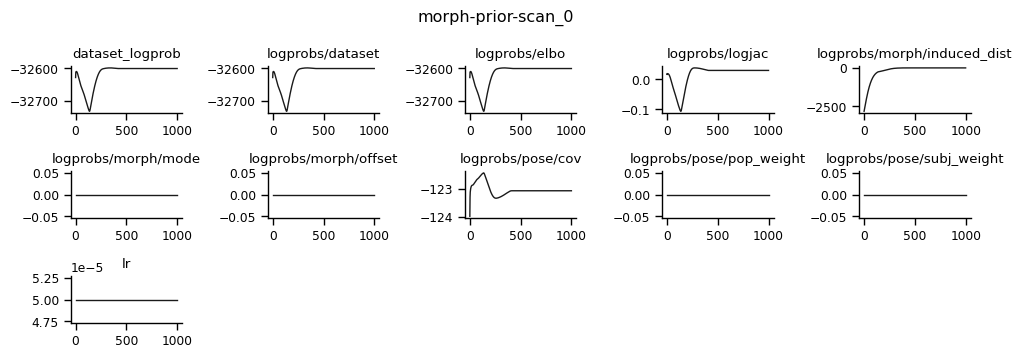

100%|██████████| 1000/1000 [00:00<00:00, 6410.21it/s]


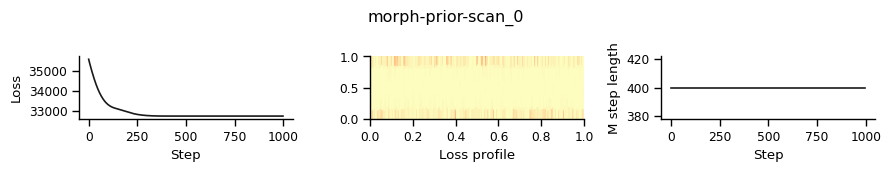

- morph


100%|██████████| 4/4 [00:00<00:00, 24.89it/s]


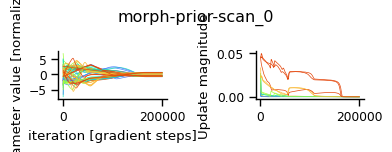

- gmm


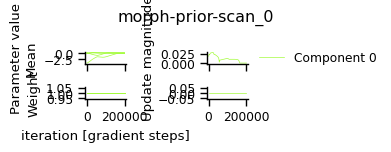

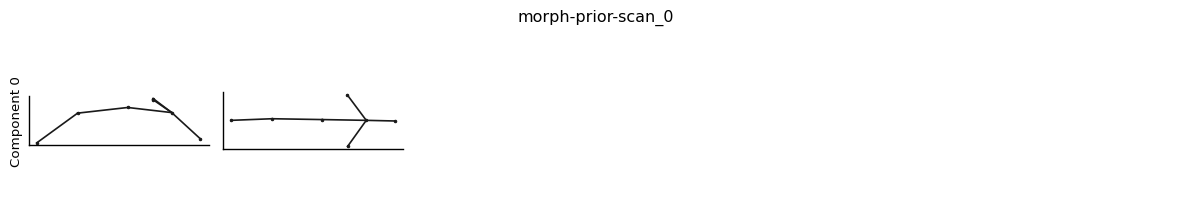

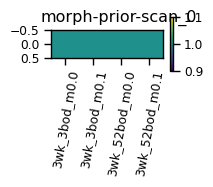

 33%|███▎      | 1/3 [00:02<00:05,  2.77s/it]

Plotting morph-prior-scan_1
- reports


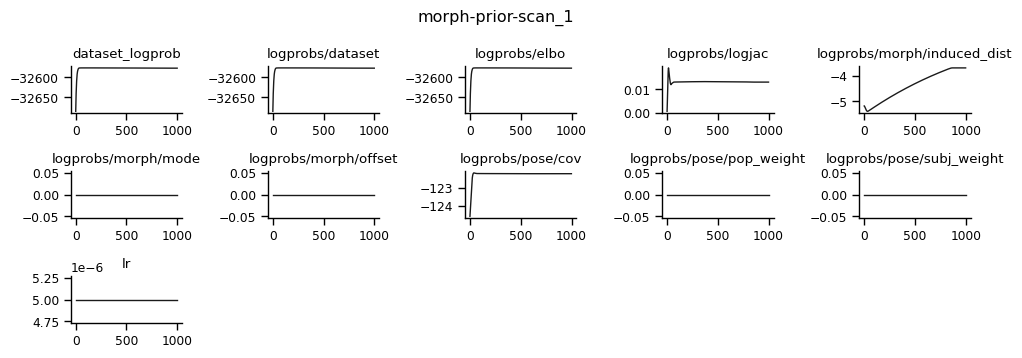

100%|██████████| 1000/1000 [00:00<00:00, 8567.64it/s]


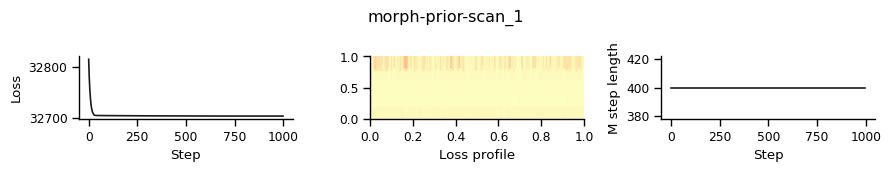

- morph


100%|██████████| 4/4 [00:00<00:00, 180.68it/s]


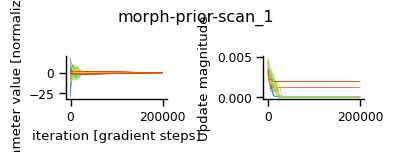

- gmm


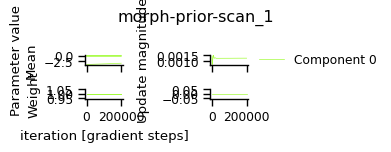

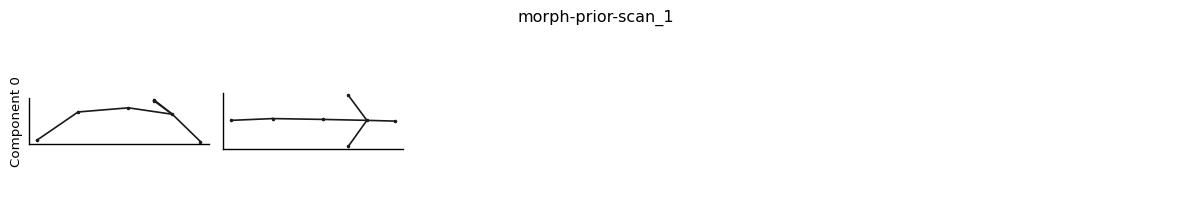

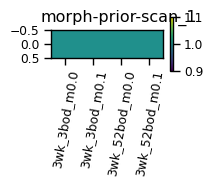

 67%|██████▋   | 2/3 [00:04<00:02,  2.41s/it]

Plotting morph-prior-scan_2
- reports


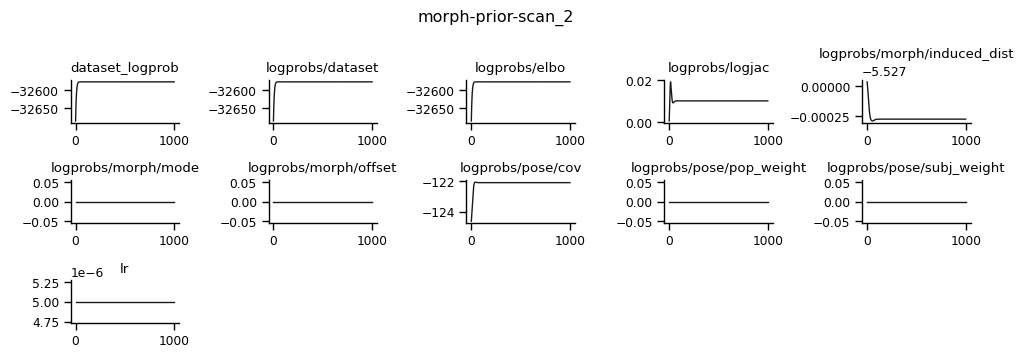

100%|██████████| 1000/1000 [00:00<00:00, 8594.92it/s]


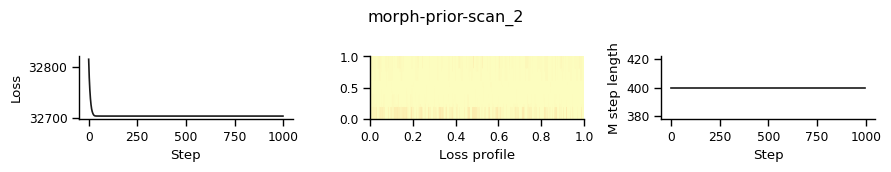

- morph


100%|██████████| 4/4 [00:00<00:00, 196.58it/s]


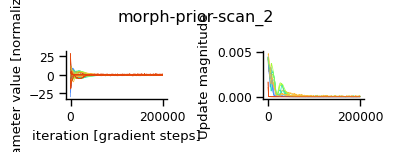

- gmm


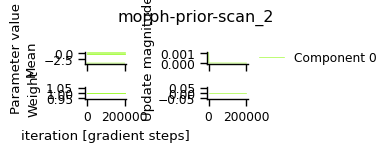

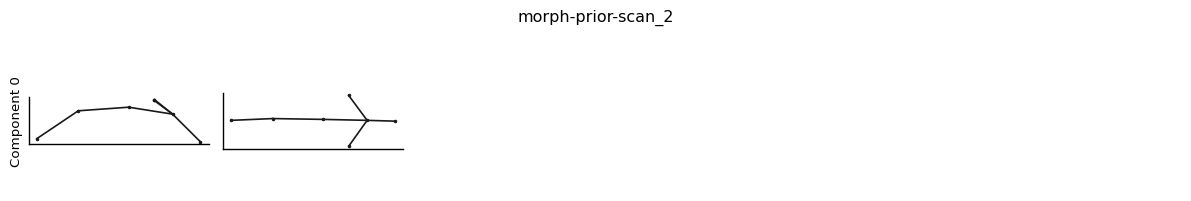

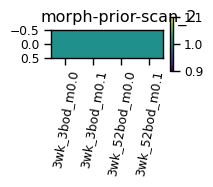

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


In [ ]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 28.38it/s]


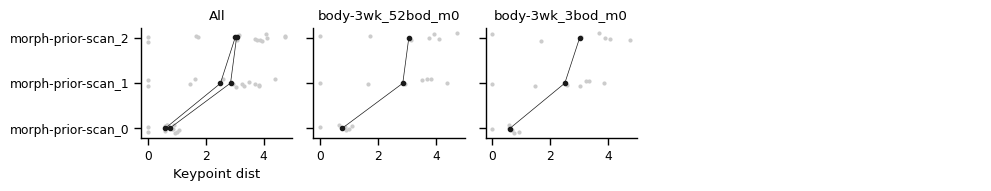

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52-pose1/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [ ]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

Unmorphed: 100%|██████████| 2/2 [00:00<00:00, 192.66it/s]
/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


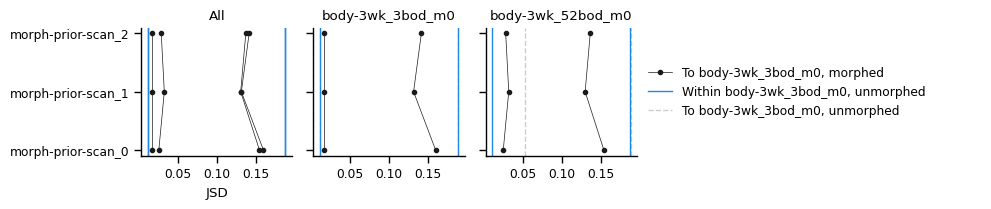

In [ ]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

### Dataset specific results

###### 1
Dataset visualization

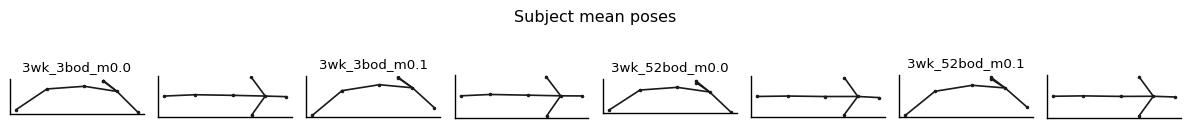

In [ ]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

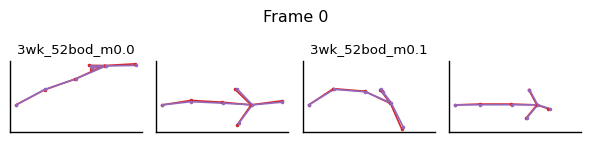

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip([3, 52], [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0', '3wk_3bod_m0.1', '3wk_52bod_m0.1']
cols = [0, 0, 2, 2]
for i, (sess, col) in enumerate(zip(sessions, cols)):
    sess_body = int(re.search(r"(\d+)bod", sess).group(1))
    viz.util.plot_mouse_views(
        ax[(col):col+2],
        inflated.get_session(sess)[0],
        arms, color = session_pal[sess_body], label=sess_body,
    )
    ax[(col)].set_title(sess)
fig.suptitle(f"Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

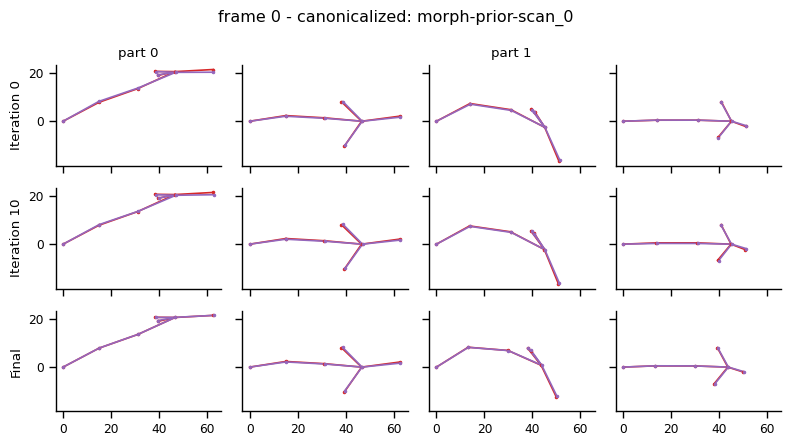

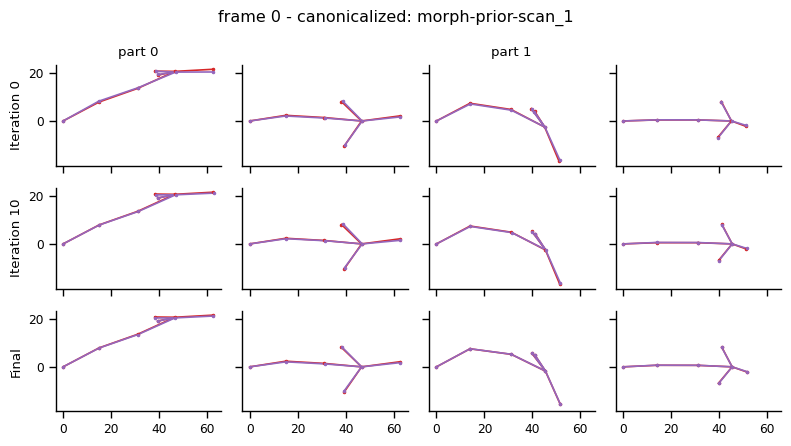

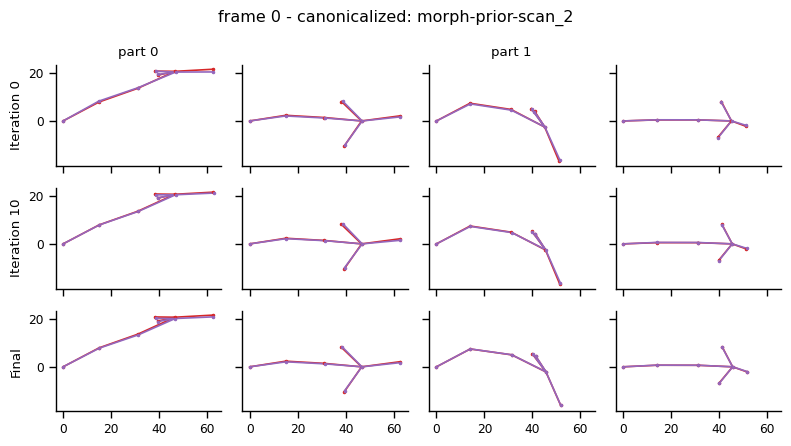

In [ ]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in ['3wk_3bod_m0', '3wk_52bod_m0']:
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


###### 4

Framewise keypoint error over training

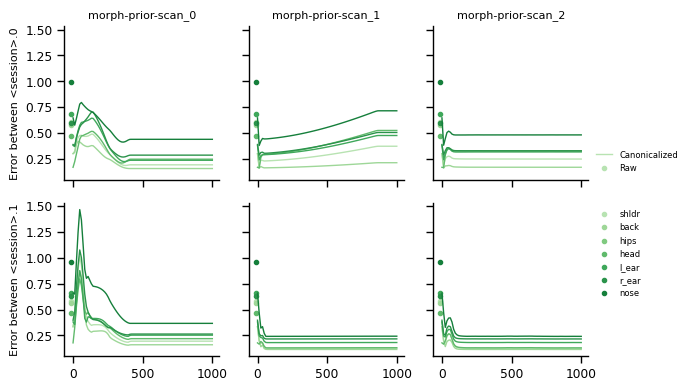

In [ ]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())
max_iter = config.load_model_config(project.model_config(models[0]))['fit']['em']['n_steps']
plot_iters = list(range(0, max_iter - 10, max_iter // 80)) + ['final']
parts = "01"

fig, ax = plt.subplots(len(parts), len(models), figsize=(2 * len(models) + 1, 2 * len(parts)), sharex=True, sharey = True)

base_errs = [[] for _ in range(len(parts))]
inflated = features.inflate(scan_dataset, cfg['features'])
for i_part, part in enumerate(parts):
    base_errs[i_part] = model_util.reconst_errs(
        inflated.get_session(f"3wk_3bod_m0.{part}"),
        inflated.get_session(f"3wk_52bod_m0.{part}"),
        average=False,
    ).mean(axis=0)
base_errs = np.array(base_errs)

for i_mod, model_name in enumerate(models):
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

    errs = [[] for _ in range(len(parts))]
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for i_part, part in enumerate(parts):
            errs[i_part].append(model_util.reconst_errs(
                inflated.get_session(f"3wk_3bod_m0.{part}"),
                inflated.get_session(f"3wk_52bod_m0.{part}"),
                average=False,
            ).mean(axis=0))
    errs = np.array(errs)

    for i_part, part in enumerate(parts):
        for i_kp in range(errs.shape[-1]):
            if cfg["dataset"]["use_keypoints"][i_kp] == 'hips':
                continue
            ax[i_part, i_mod].plot(_x, errs[i_part, :, i_kp], color=kp_colors[i_kp], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_part, i_mod].plot([-_x[1]], [base_errs[i_part, i_kp]], 'o', color=kp_colors[i_kp], lw = 0, ms = 3, label = "Raw")
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_part, 0].set_ylabel(f"Error between <session>.{part}", fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=kp_colors[i_kp], ms = 3, label = cfg["dataset"]["use_keypoints"][i_kp])[0]
    for i_kp in range(errs.shape[-1])
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


## More than one GMM component

Key hyperparameter settings to make this work:
- Loosening subject uniformity prior
- Speeding up GMM learning rate
- Fitting for a long time

### Project and dataset setup

In [10]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "individual" / f"{base}wk_m0-to-52wk.yaml"
scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"


project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')


Loading keypoints: 100%|█████████████████| 1/1 [00:00<00:00, 282.88it/s]

Sessions: ['3wk_3bod_m0', '3wk_52bod_m0']


In [11]:
# Create base project config to override

project_dir = Path('../projects/blscale-test/3wk-to-52')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



### Calibration and training

In [28]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=1000,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["pose"]["subj_weight_uniformity"] = 1
cfg["fit"]["n_steps"] = 1000
cfg["fit"]["learning_rate"] = 5e-1
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["update_scales"] = {'pose/*': 1e1}

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 1000 frames
INFO:root:Fitting GMM to 1000 frames
INFO:root:Fitting GMM to 1000 frames
INFO:root:Fitting GMM to 1000 frames
INFO:root:Fitting GMM to 1000 frames
INFO:root:Fitting GMM to 1000 frames
INFO:root:Fitting GMM to 1000 frames


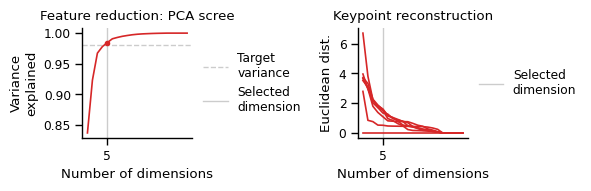

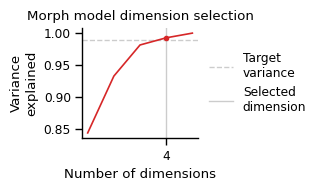

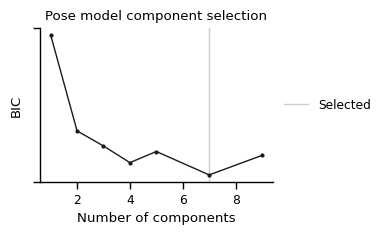

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52/scans/morph-prior-scan/plots/pose_calibration.pdf')

In [21]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

###### scan setup

define scans to test various configurations

In [66]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate': [1e-1, 1e-2, 1e-2],
    'fit.em.n_steps': [1000, 3000, 3000],
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

###### fitting

`scans.run_scan`

In [67]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20)

INFO:root:Model at /Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52/models/morph-prior-scan_0 is already up to date.
INFO:root:Model at /Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52/models/morph-prior-scan_1 is already up to date.
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:0.01 -> 5e-06
INFO:root:Loading LR schedule: const
INFO:root:Scaling param: pose/subj_weight_logits,shape (4, 7) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (7,) by 10.0
INFO:root:Scaling param: pose/means,shape (7, 5) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (7, 15) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (4, 5, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (4, 5)
INFO:root:Scaling param: pose/subj_weight_logits,shape (4, 7) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (7,) by 10.0

### Standard training diagnostics

Reloading 'shape_norm.pca'.
Reloading 'shape_norm.models.morph.lowrank_affine'.


  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


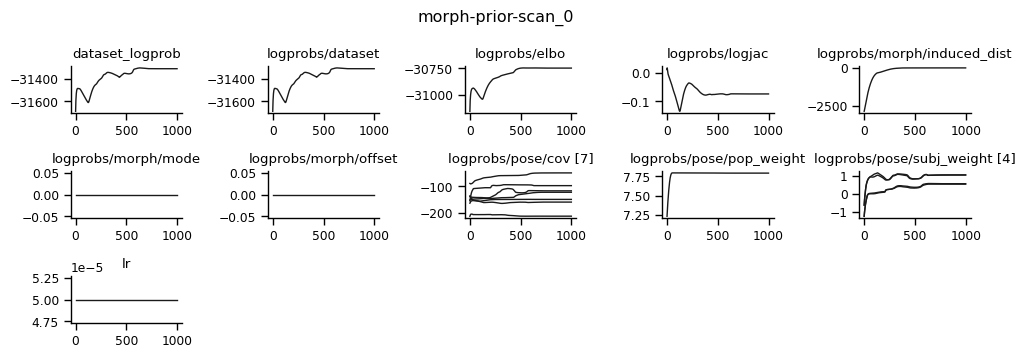

100%|██████████| 1000/1000 [00:00<00:00, 8746.77it/s]


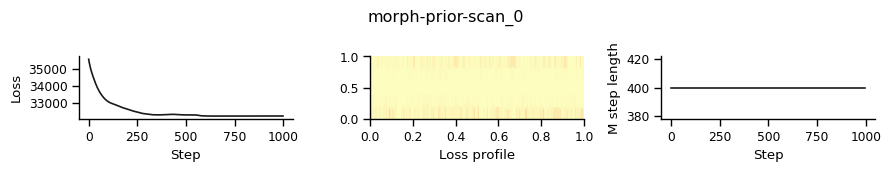

- morph


100%|██████████| 4/4 [00:00<00:00, 214.89it/s]


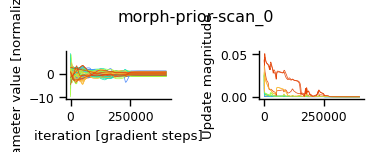

- gmm


/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


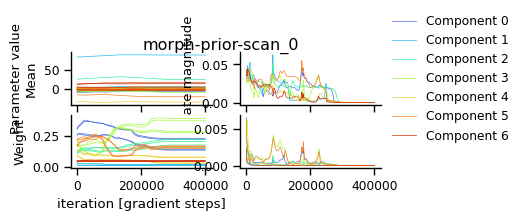

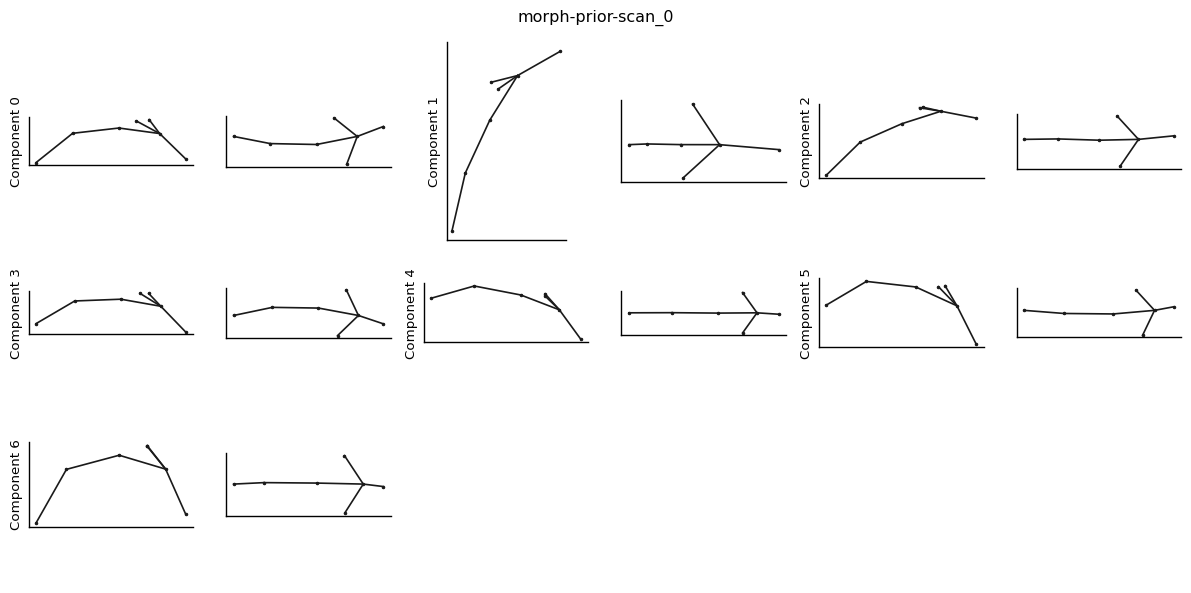

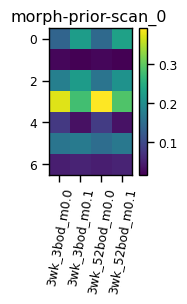

 33%|███▎      | 1/3 [00:02<00:04,  2.40s/it]

Plotting morph-prior-scan_1
- reports


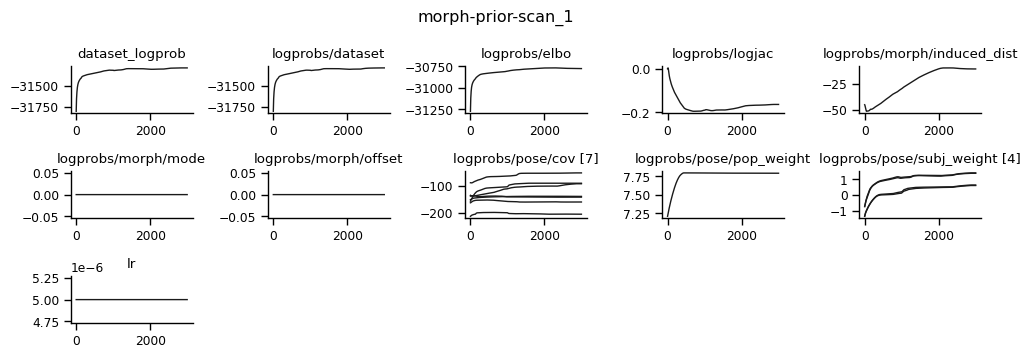

100%|██████████| 3000/3000 [00:00<00:00, 9106.19it/s]


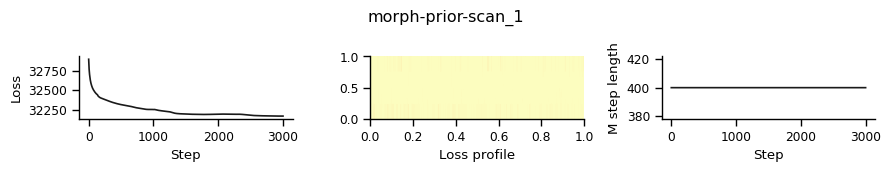

- morph


100%|██████████| 4/4 [00:00<00:00, 172.01it/s]


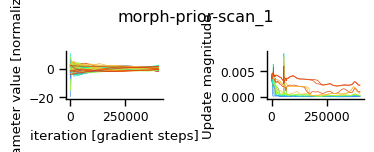

- gmm


/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


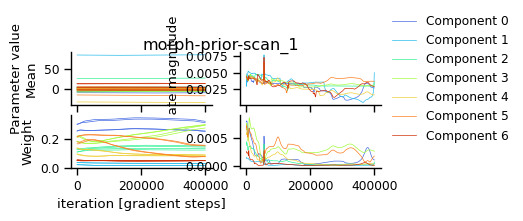

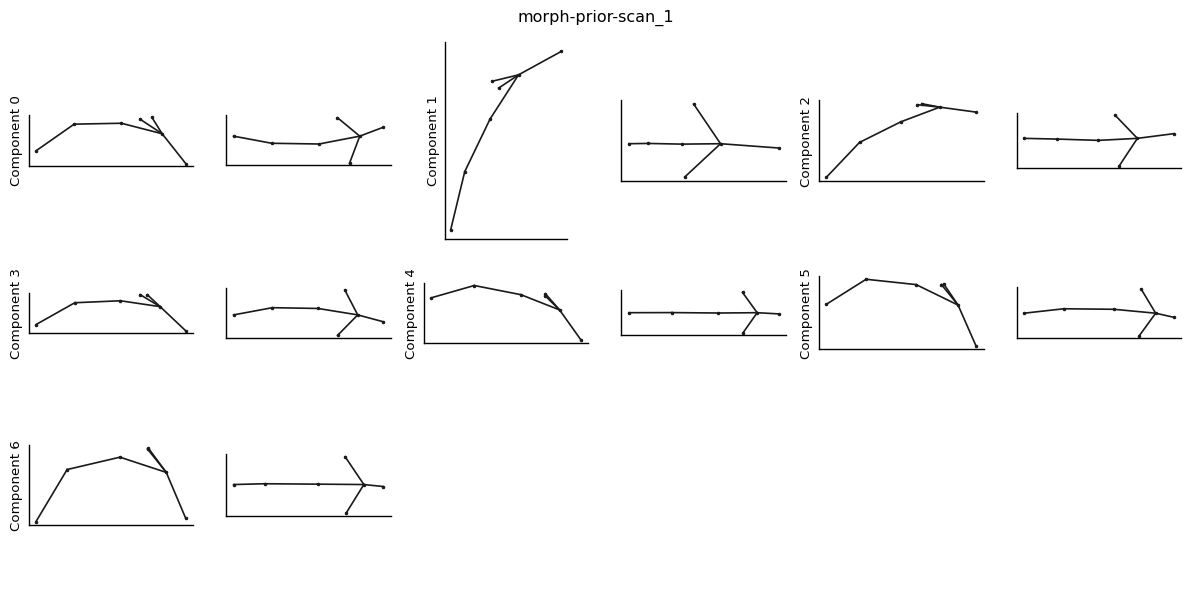

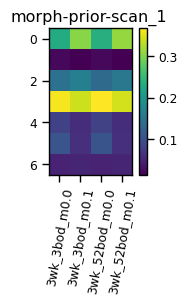

 67%|██████▋   | 2/3 [00:05<00:03,  3.00s/it]

Plotting morph-prior-scan_2
- reports


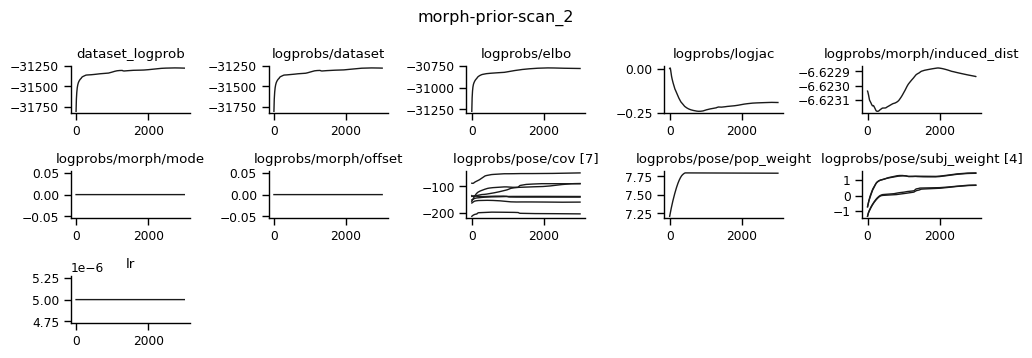

100%|██████████| 3000/3000 [00:00<00:00, 9132.72it/s]


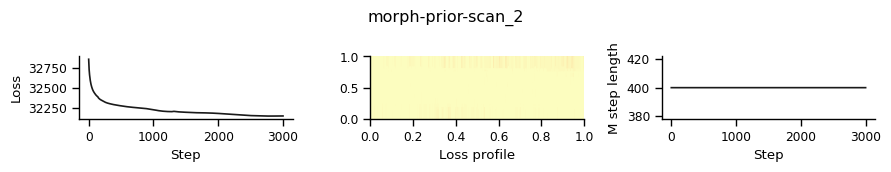

- morph


100%|██████████| 4/4 [00:00<00:00, 104.61it/s]


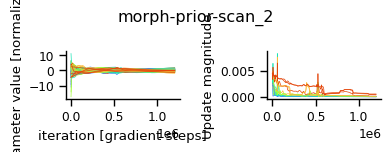

- gmm


/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


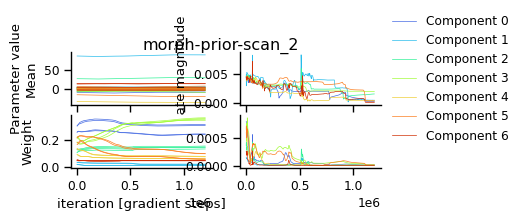

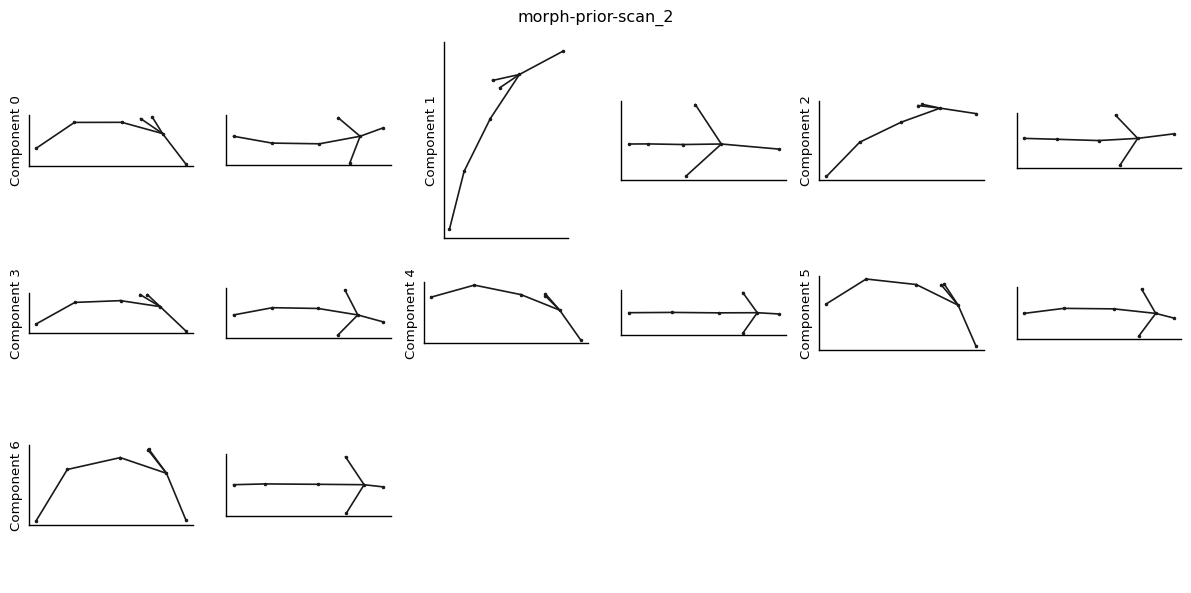

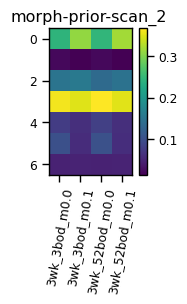

100%|██████████| 3/3 [00:09<00:00,  3.20s/it]


In [68]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 25.97it/s]


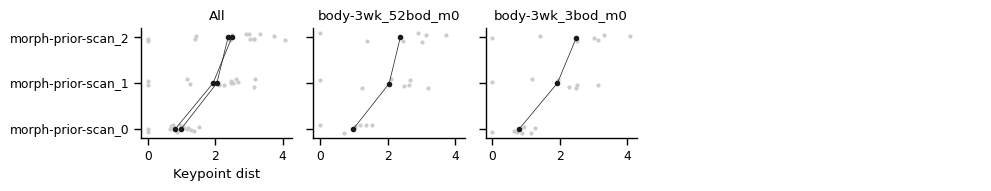

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [71]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

Unmorphed: 100%|██████████| 2/2 [00:00<00:00, 194.76it/s]
/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


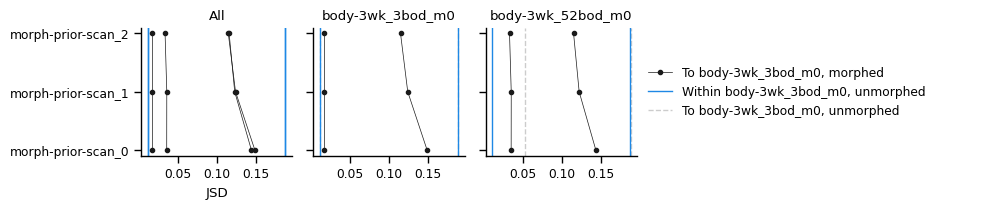

In [72]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

### Dataset specific results

###### 1
Dataset visualization

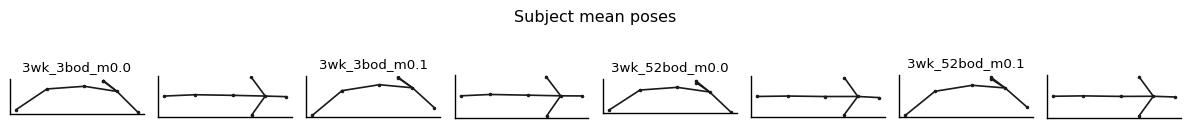

In [ ]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

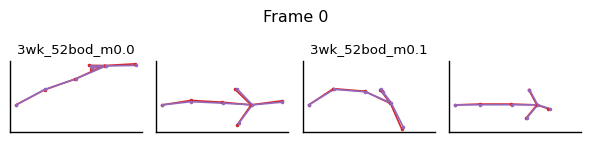

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip([3, 52], [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0', '3wk_3bod_m0.1', '3wk_52bod_m0.1']
cols = [0, 0, 2, 2]
for i, (sess, col) in enumerate(zip(sessions, cols)):
    sess_body = int(re.search(r"(\d+)bod", sess).group(1))
    viz.util.plot_mouse_views(
        ax[(col):col+2],
        inflated.get_session(sess)[0],
        arms, color = session_pal[sess_body], label=sess_body,
    )
    ax[(col)].set_title(sess)
fig.suptitle(f"Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

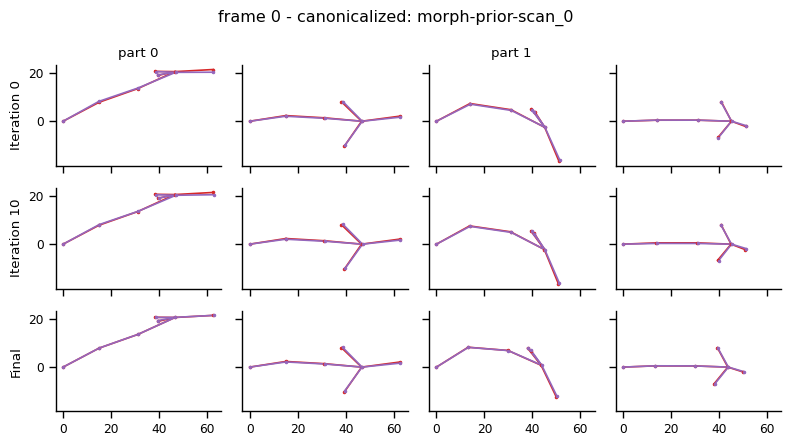

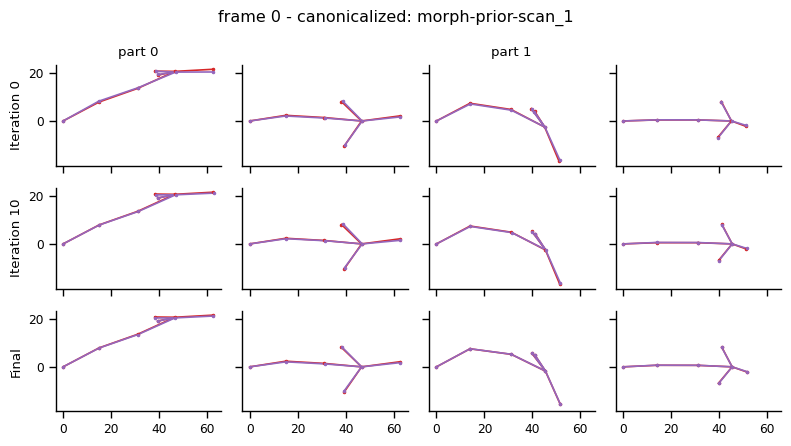

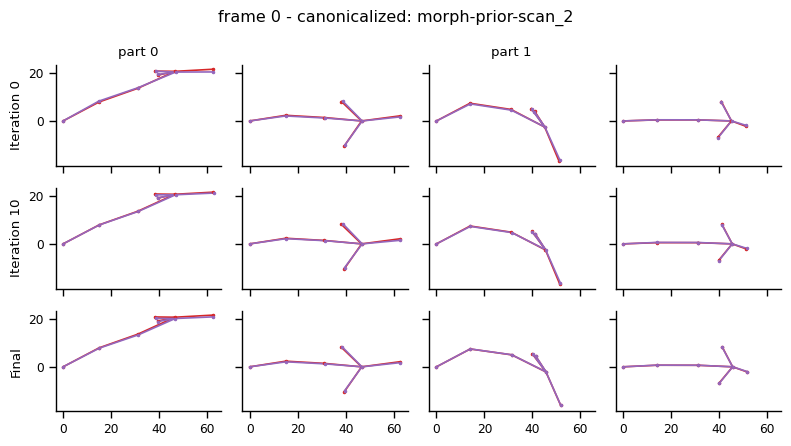

In [ ]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in ['3wk_3bod_m0', '3wk_52bod_m0']:
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


###### 4

Framewise keypoint error over training

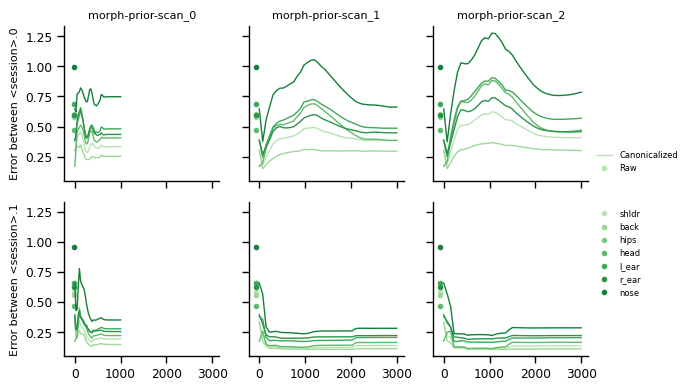

In [73]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())
parts = "01"

fig, ax = plt.subplots(len(parts), len(models), figsize=(2 * len(models) + 1, 2 * len(parts)), sharex=True, sharey = True)

base_errs = [[] for _ in range(len(parts))]
inflated = features.inflate(scan_dataset, cfg['features'])
for i_part, part in enumerate(parts):
    base_errs[i_part] = model_util.reconst_errs(
        inflated.get_session(f"3wk_3bod_m0.{part}"),
        inflated.get_session(f"3wk_52bod_m0.{part}"),
        average=False,
    ).mean(axis=0)
base_errs = np.array(base_errs)

for i_mod, model_name in enumerate(models):

    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    max_iter = cfg['fit']['em']['n_steps']
    plot_iters = list(range(0, max_iter - 10, max_iter // 40)) + ['final']
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

    errs = [[] for _ in range(len(parts))]
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for i_part, part in enumerate(parts):
            errs[i_part].append(model_util.reconst_errs(
                inflated.get_session(f"3wk_3bod_m0.{part}"),
                inflated.get_session(f"3wk_52bod_m0.{part}"),
                average=False,
            ).mean(axis=0))
    errs = np.array(errs)

    for i_part, part in enumerate(parts):
        for i_kp in range(errs.shape[-1]):
            if cfg["dataset"]["use_keypoints"][i_kp] == 'hips':
                continue
            ax[i_part, i_mod].plot(_x, errs[i_part, :, i_kp], color=kp_colors[i_kp], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_part, i_mod].plot([-_x[1]], [base_errs[i_part, i_kp]], 'o', color=kp_colors[i_kp], lw = 0, ms = 3, label = "Raw")
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_part, 0].set_ylabel(f"Error between <session>.{part}", fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=kp_colors[i_kp], ms = 3, label = cfg["dataset"]["use_keypoints"][i_kp])[0]
    for i_kp in range(errs.shape[-1])
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


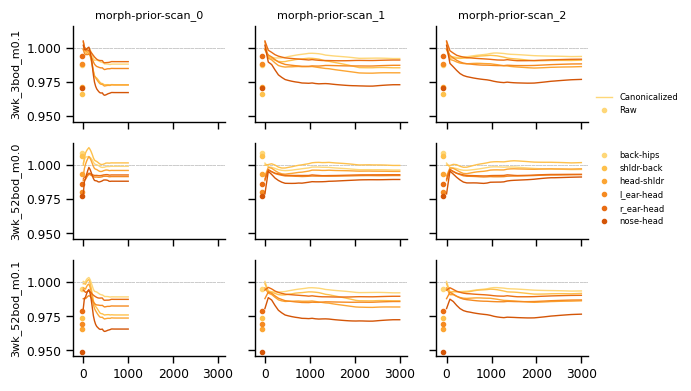

In [74]:
# bone length over training

# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
bo_colors = Colormap('whorbr')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())
parts = "01"

cfg = config.load_project_config(project.main_config())
arms = Armature.from_config(cfg["dataset"])
_bone_lengths = lambda kpts, arms: jnp.linalg.norm(kpts[:, arms.bones[:, 0]] - kpts[:, arms.bones[:, 1]], axis=-1)
_bone_name = lambda i: f"{arms.keypoint_names[int(arms.bones[i, 0])]}-{arms.keypoint_names[int(arms.bones[i, 1])]}"
bone_names = [_bone_name(i) for i in range(arms.bones.shape[0])]
inflated = features.inflate(scan_dataset, cfg['features'])
base_bls = _bone_lengths(inflated.get_session(scan_dataset.ref_session), arms).mean(axis=0)
base_rtos = {
    s: _bone_lengths(inflated.get_session(s), arms).mean(axis=0) / base_bls
    for s in scan_dataset.sessions
}
sessions = [s for s in scan_dataset.sessions if scan_dataset.session_id(s) != scan_dataset.ref_session]


fig, ax = plt.subplots(len(sessions), len(models), figsize=(2 * len(models) + 1, 2 * len(parts)), sharex=True, sharey = True)

for i_mod, model_name in enumerate(models):

    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    max_iter = cfg['fit']['em']['n_steps']
    plot_iters = list(range(0, max_iter - 10, max_iter // 40)) + ['final']
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

    bls = {s: [] for s in sessions}
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for s in bls:
            bls[s].append(_bone_lengths(inflated.get_session(s), arms).mean(axis=0))
    bls = {k: np.array(a) for k, a in bls.items()}
    

    for i_s, s in enumerate(bls):
        for i_b, b_name in enumerate(bone_names):
            ax[i_s, i_mod].plot(_x, bls[s][:, i_b] / base_bls[i_b], color=bo_colors[i_b], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_s, i_mod].plot([-_x[1]], [base_rtos[s][i_b]], 'o', color=bo_colors[i_b], lw = 0, ms = 3, label = "Raw")
            ax[i_s, i_mod].axhline(1., color = '.8', lw = 0.5, ls = '--', zorder = -1)
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_s, 0].set_ylabel(s, fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=bo_colors[i_b], ms = 3, label = b_name)[0]
    for i_b, b_name in enumerate(bone_names)
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


## More than one source session

- `3wk-to-52wk` source dict instead of only `m0`, but sessions other than `m0`
  and `m1` removed.
- Decreased number of frames.
    - As a result also decreased number of components chosen from BIC
      initialization.

### Project and dataset setup

In [7]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "cohort-wise" / f"{base}wk-to-52wk.yaml"
scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"

source_dict = YAML().load(source_dict)
source_dict.pop('3wk_3bod_m2')
source_dict.pop('3wk_3bod_m3')
source_dict.pop('3wk_52bod_m2')
source_dict.pop('3wk_52bod_m3')

project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')


Loading keypoints: 100%|█████████████████| 2/2 [00:00<00:00, 330.31it/s]

Sessions: ['3wk_52bod_m1', '3wk_52bod_m0', '3wk_3bod_m1', '3wk_3bod_m0']


In [8]:
# Create base project config to override

project_dir = Path('../projects/blscale-test/3wk-to-52')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



### Calibration and training

In [48]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=200,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["pose"]["subj_weight_uniformity"] = 1
cfg["fit"]["n_steps"] = 1000
cfg["fit"]["learning_rate"] = 5e-1
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["update_scales"] = {'pose/*': 1e1}

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames


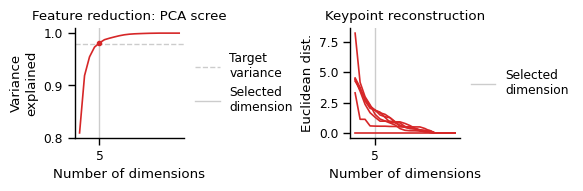

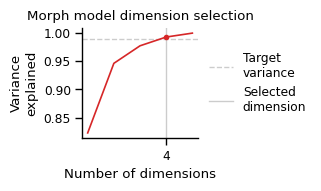

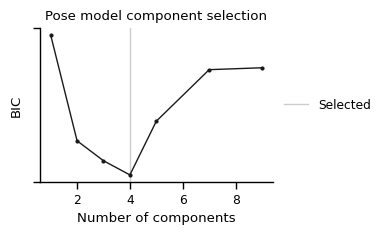

PosixPath('../projects/blscale-test/3wk-to-52/plots/pose_calibration.pdf')

In [49]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

###### scan setup

define scans to test various configurations

In [58]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate': [3e-2, 3e-2, 3e-2],
    'fit.em.n_steps': [1000, 1000, 1000],
})

scan_cfg, model_cfg = scans.setup_scan_config(project, "init-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate': [1e0, 8e-1, 8e-1],
    'fit.em.n_steps': [500, 500, 500],
    'morph.init.type': ['covariance', 'covariance', 'covariance'],
})

In [9]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "init-scan", return_session_inv=True)

###### fitting

`scans.run_scan`

In [60]:
scans.run_scan(project, "init-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52/models/init-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 100 frames
INFO:root:Adjusting learning rate:1.0 -> 0.00125
INFO:root:Loading LR schedule: const
INFO:root:Scaling param: pose/subj_weight_logits,shape (8, 4) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (4,) by 10.0
INFO:root:Scaling param: pose/means,shape (4, 5) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (4, 15) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (8, 5, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (8, 5)
INFO:root:Scaling param: pose/subj_weight_logits,shape (8, 4) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (4,) by 10.0
INFO:root:Scaling param: pose/means,shape (4, 5) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (4, 15) by 10.0
INFO:root:Unscaled param: morph/_mode_upda

### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting init-scan_0
- reports


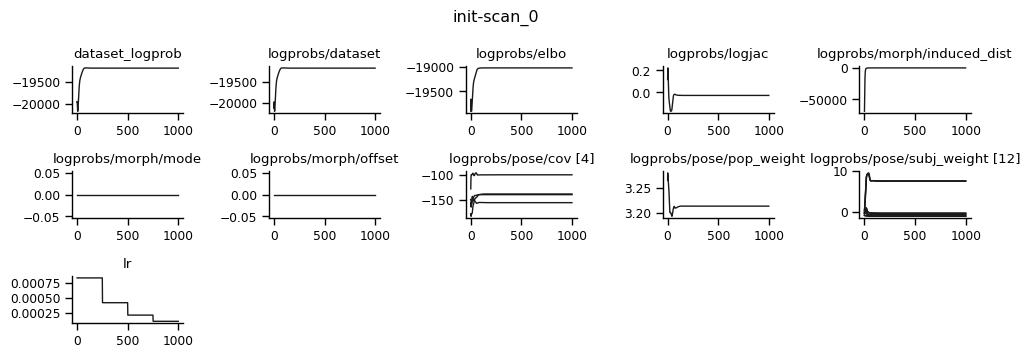

100%|██████████| 1000/1000 [00:00<00:00, 7242.92it/s]


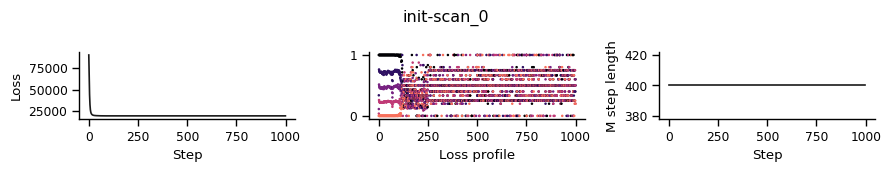

- morph


100%|██████████| 12/12 [00:00<00:00, 156.49it/s]


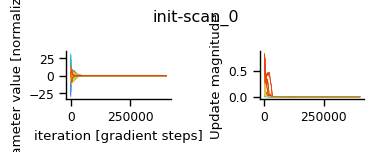

- gmm


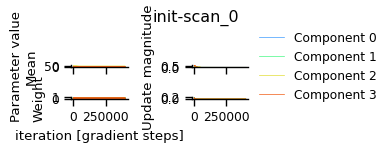

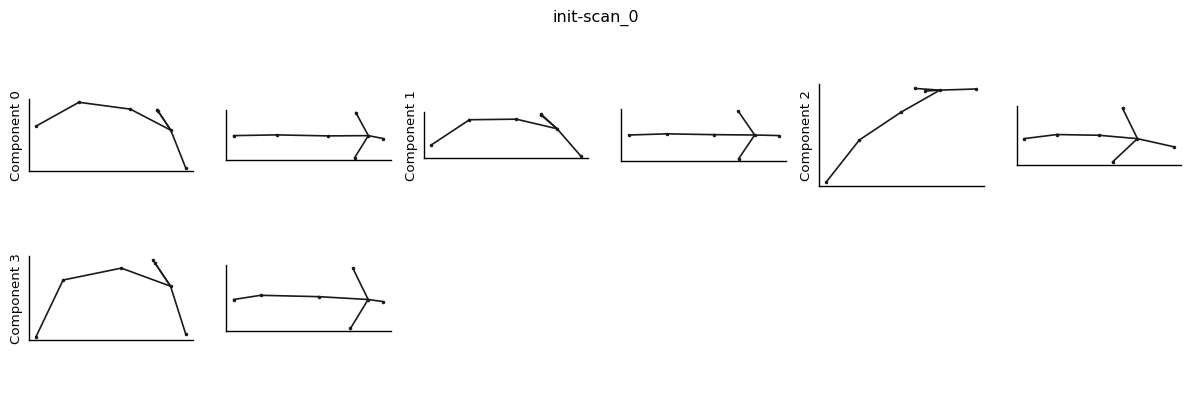

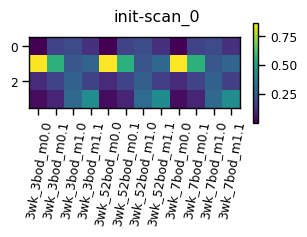

 33%|███▎      | 1/3 [00:02<00:04,  2.31s/it]

Plotting init-scan_1
- reports


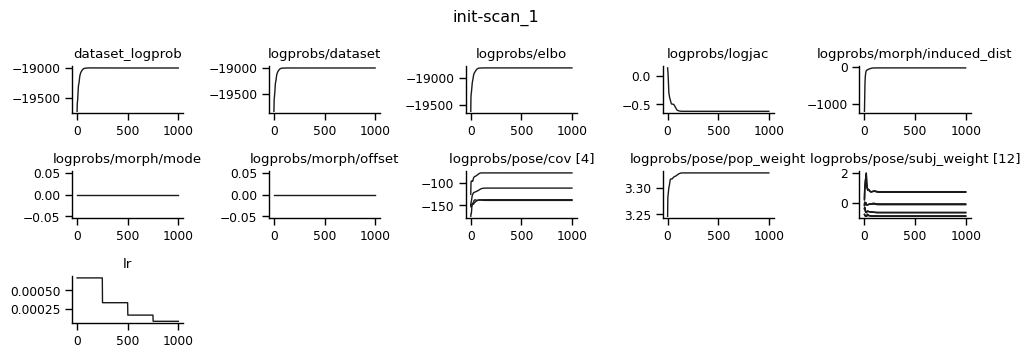

100%|██████████| 1000/1000 [00:00<00:00, 8363.87it/s]


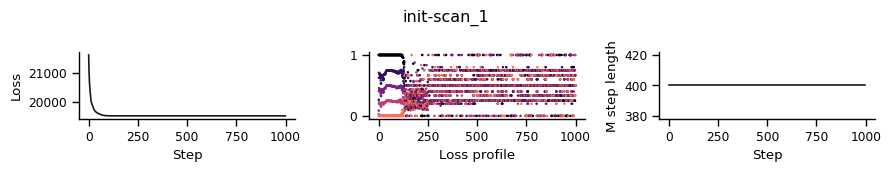

- morph


100%|██████████| 12/12 [00:00<00:00, 168.56it/s]


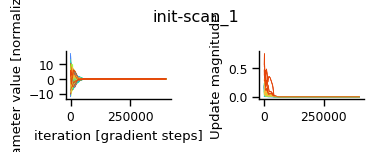

- gmm


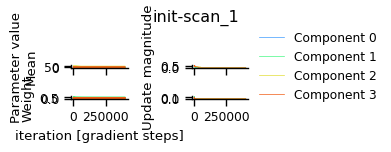

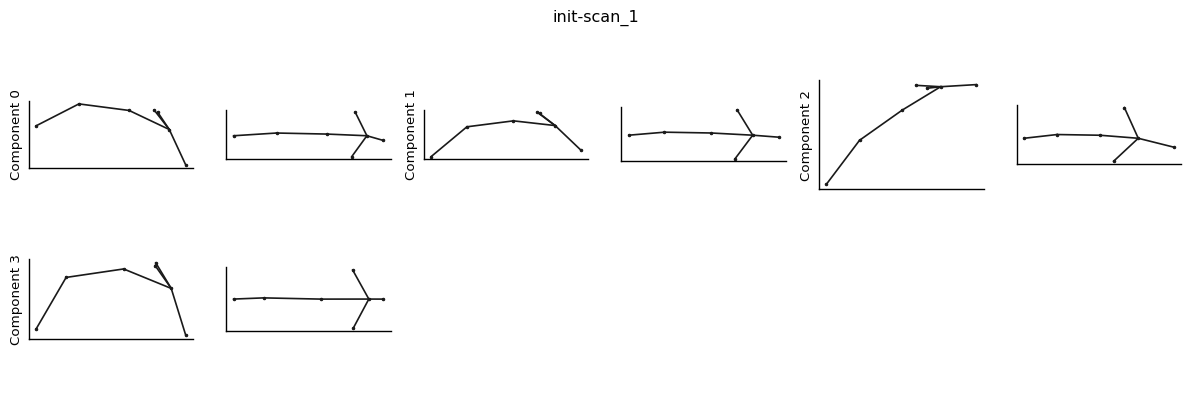

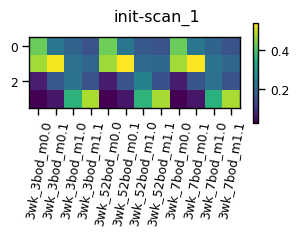

 67%|██████▋   | 2/3 [00:04<00:02,  2.11s/it]

Plotting init-scan_2
- reports


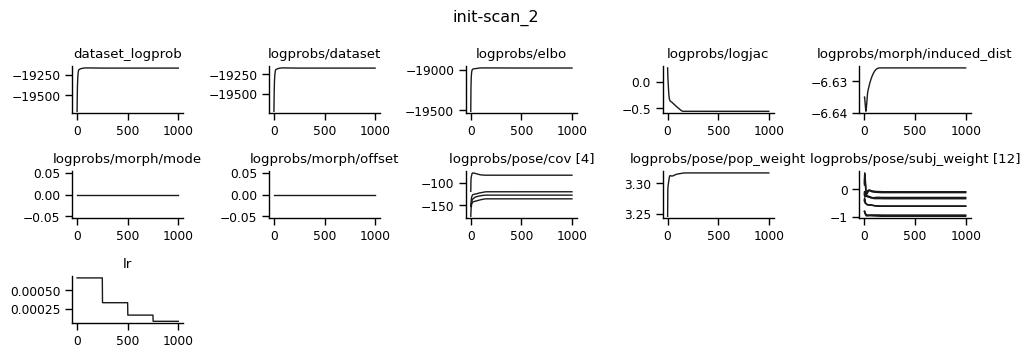

100%|██████████| 1000/1000 [00:00<00:00, 7038.24it/s]


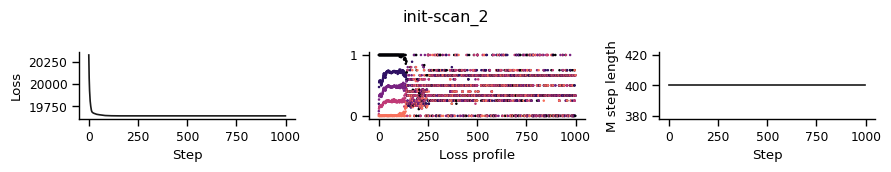

- morph


100%|██████████| 12/12 [00:00<00:00, 40.22it/s]


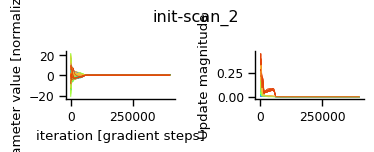

- gmm


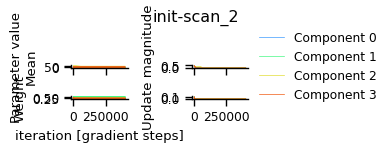

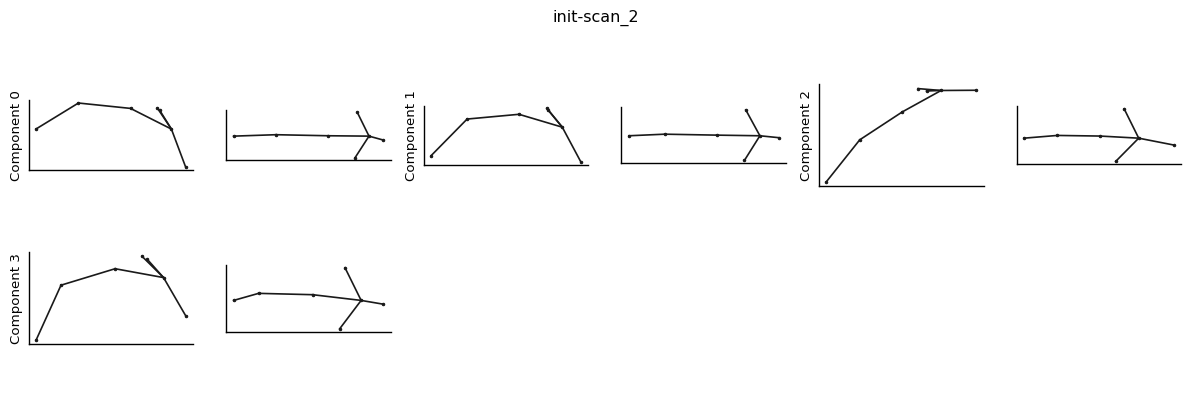

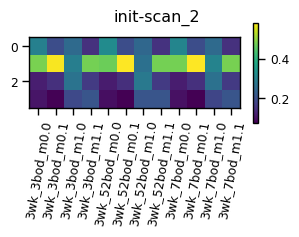

100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


In [117]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt, final_mstep=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 25.93it/s]


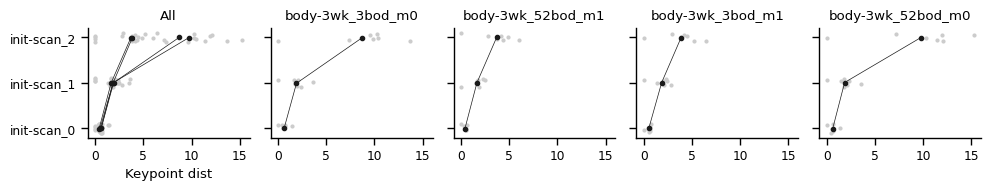

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-52/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [62]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

Unmorphed: 100%|██████████| 4/4 [00:00<00:00, 1181.99it/s]


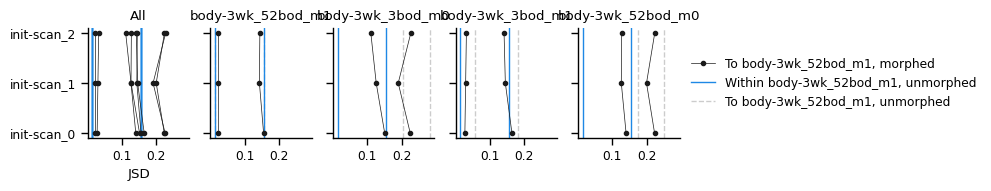

In [63]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

### Dataset specific results

###### 1
Dataset visualization

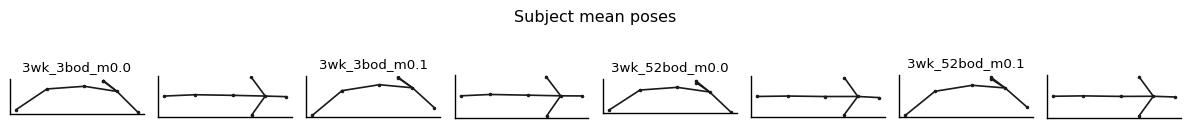

In [ ]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

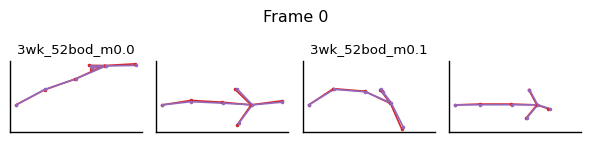

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip([3, 52], [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0', '3wk_3bod_m0.1', '3wk_52bod_m0.1']
cols = [0, 0, 2, 2]
for i, (sess, col) in enumerate(zip(sessions, cols)):
    sess_body = int(re.search(r"(\d+)bod", sess).group(1))
    viz.util.plot_mouse_views(
        ax[(col):col+2],
        inflated.get_session(sess)[0],
        arms, color = session_pal[sess_body], label=sess_body,
    )
    ax[(col)].set_title(sess)
fig.suptitle(f"Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

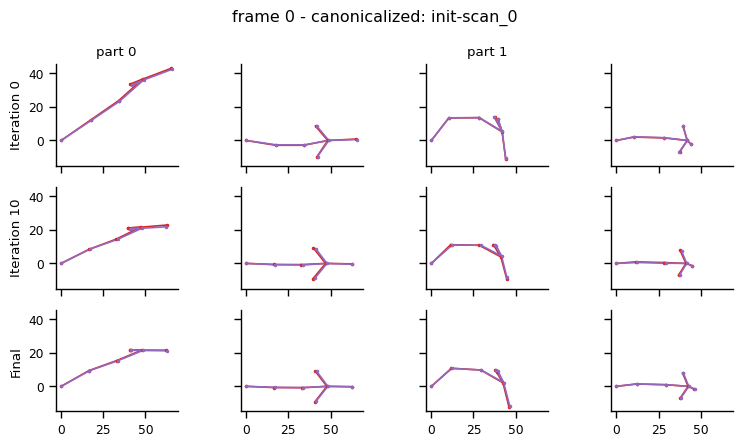

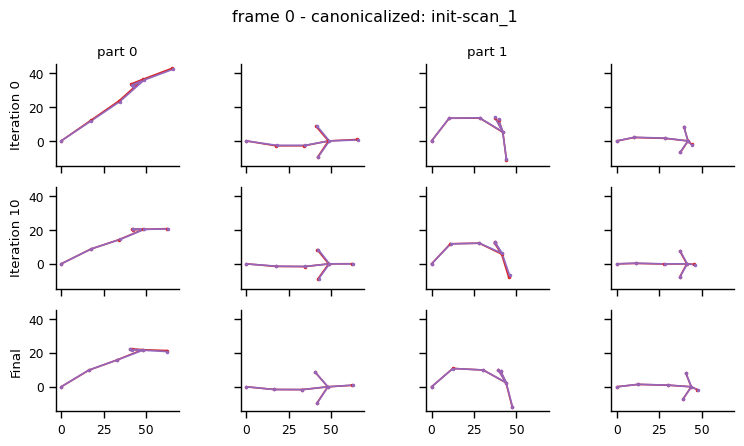

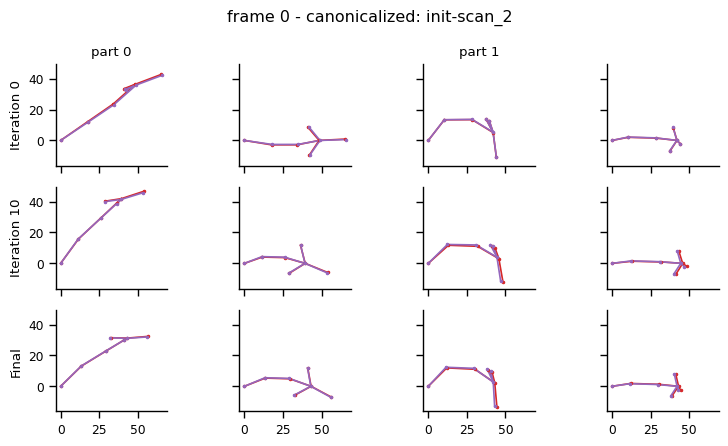

In [64]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in ['3wk_3bod_m0', '3wk_52bod_m0']:
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


###### 4

Framewise keypoint error over training

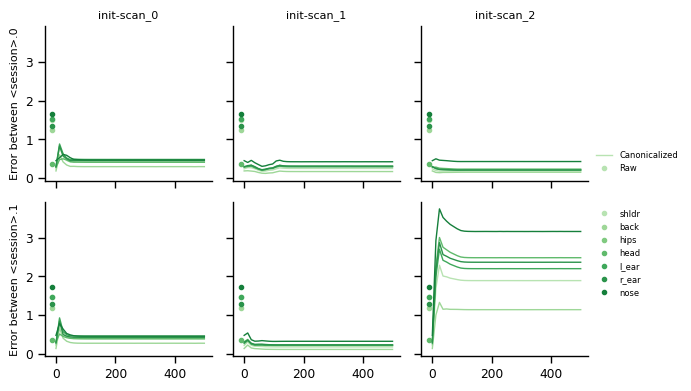

In [65]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())
parts = "01"

fig, ax = plt.subplots(len(parts), len(models), figsize=(2 * len(models) + 1, 2 * len(parts)), sharex=True, sharey = True)

base_errs = [[] for _ in range(len(parts))]
inflated = features.inflate(scan_dataset, cfg['features'])
for i_part, part in enumerate(parts):
    base_errs[i_part] = model_util.reconst_errs(
        inflated.get_session(f"3wk_3bod_m0.{part}"),
        inflated.get_session(f"3wk_52bod_m0.{part}"),
        average=False,
    ).mean(axis=0)
base_errs = np.array(base_errs)

for i_mod, model_name in enumerate(models):

    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    max_iter = cfg['fit']['em']['n_steps']
    plot_iters = list(range(0, max_iter - 10, max_iter // 40)) + ['final']
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

    errs = [[] for _ in range(len(parts))]
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for i_part, part in enumerate(parts):
            errs[i_part].append(model_util.reconst_errs(
                inflated.get_session(f"3wk_3bod_m0.{part}"),
                inflated.get_session(f"3wk_52bod_m0.{part}"),
                average=False,
            ).mean(axis=0))
    errs = np.array(errs)

    for i_part, part in enumerate(parts):
        for i_kp in range(errs.shape[-1]):
            if cfg["dataset"]["use_keypoints"][i_kp] == 'hips':
                continue
            ax[i_part, i_mod].plot(_x, errs[i_part, :, i_kp], color=kp_colors[i_kp], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_part, i_mod].plot([-_x[1]], [base_errs[i_part, i_kp]], 'o', color=kp_colors[i_kp], lw = 0, ms = 3, label = "Raw")
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_part, 0].set_ylabel(f"Error between <session>.{part}", fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=kp_colors[i_kp], ms = 3, label = cfg["dataset"]["use_keypoints"][i_kp])[0]
    for i_kp in range(errs.shape[-1])
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


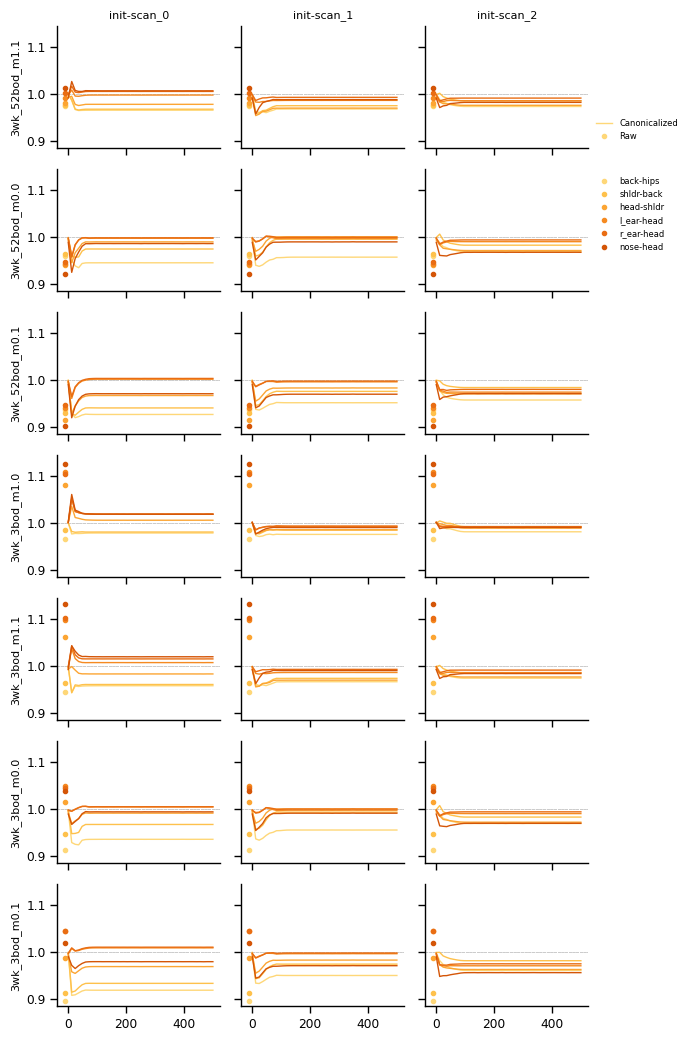

In [67]:
# bone length over training

# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
bo_colors = Colormap('whorbr')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())
parts = "01"

cfg = config.load_project_config(project.main_config())
arms = Armature.from_config(cfg["dataset"])
_bone_lengths = lambda kpts, arms: jnp.linalg.norm(kpts[:, arms.bones[:, 0]] - kpts[:, arms.bones[:, 1]], axis=-1)
_bone_name = lambda i: f"{arms.keypoint_names[int(arms.bones[i, 0])]}-{arms.keypoint_names[int(arms.bones[i, 1])]}"
bone_names = [_bone_name(i) for i in range(arms.bones.shape[0])]
inflated = features.inflate(scan_dataset, cfg['features'])
base_bls = _bone_lengths(inflated.get_session(scan_dataset.ref_session), arms).mean(axis=0)
base_rtos = {
    s: _bone_lengths(inflated.get_session(s), arms).mean(axis=0) / base_bls
    for s in scan_dataset.sessions
}
sessions = [s for s in scan_dataset.sessions if scan_dataset.session_id(s) != scan_dataset.ref_session]


fig, ax = plt.subplots(len(sessions), len(models), figsize=(2 * len(models) + 1, 1.5 * len(sessions)), sharex=True, sharey = True)

for i_mod, model_name in enumerate(models):

    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    max_iter = cfg['fit']['em']['n_steps']
    plot_iters = list(range(0, max_iter - 10, max_iter // 40)) + ['final']
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

    bls = {s: [] for s in sessions}
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for s in bls:
            bls[s].append(_bone_lengths(inflated.get_session(s), arms).mean(axis=0))
    bls = {k: np.array(a) for k, a in bls.items()}
    

    for i_s, s in enumerate(bls):
        for i_b, b_name in enumerate(bone_names):
            ax[i_s, i_mod].plot(_x, bls[s][:, i_b] / base_bls[i_b], color=bo_colors[i_b], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_s, i_mod].plot([-_x[1]], [base_rtos[s][i_b]], 'o', color=bo_colors[i_b], lw = 0, ms = 3, label = "Raw")
            ax[i_s, i_mod].axhline(1., color = '.8', lw = 0.5, ls = '--', zorder = -1)
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_s, 0].set_ylabel(s, fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=bo_colors[i_b], ms = 3, label = b_name)[0]
    for i_b, b_name in enumerate(bone_names)
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


## Multiple target ages

- `3wk-to-all` source dict instead of only to `52wk`, but only `3bod`, `7bod`
  and `52bod` kept.
- Still very small number of frames (cautious to bring below 200)

### Project and dataset setup

In [47]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "cohort-wise" / f"{base}wk-to-all.yaml"
scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"

source_dict = YAML().load(source_dict)
for k in list(source_dict.keys()):
    if not (k.endswith('m0') or k.endswith('m1')):
        source_dict.pop(k)
        continue
    if not (('3bod' in k) or ('52bod' in k) or ('7bod' in k)):
        source_dict.pop(k)

project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')


Loading keypoints: 100%|█████████████████| 2/2 [00:00<00:00, 366.15it/s]


Sessions: ['3wk_52bod_m1', '3wk_52bod_m0', '3wk_3bod_m1', '3wk_3bod_m0', '3wk_7bod_m1', '3wk_7bod_m0']


In [48]:
# Create base project config to override

project_dir = Path('../projects/blscale-test/3wk-to-07-52')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



### Calibration and training

In [33]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=200,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["pose"]["subj_weight_uniformity"] = 1
cfg["fit"]["n_steps"] = 1000
cfg["fit"]["learning_rate"] = dict(kind='stair', hl = 250, lr = 5e-1, min = 1e-5)
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["update_scales"] = {'pose/*': 1e1}

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames


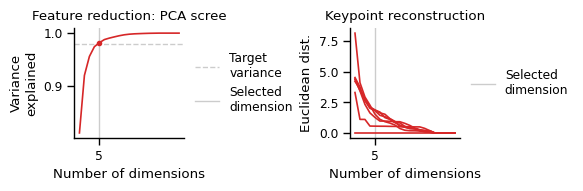

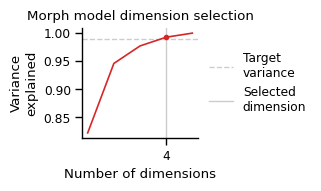

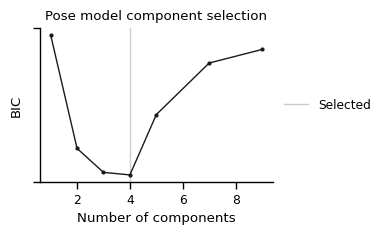

PosixPath('../projects/blscale-test/3wk-to-07-52/plots/pose_calibration.pdf')

In [34]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

###### scan setup

define scans to test various configurations

In [114]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate.lr': [1e0, 8e-1, 8e-1],
    'fit.em.n_steps': [1000, 1000, 1000],
})

scan_cfg, model_cfg = scans.setup_scan_config(project, "init-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate.lr': [1e0, 8e-1, 8e-1],
    'fit.em.n_steps': [1000, 1000, 1000],
    'morph.init.type': ['covariance', 'covariance', 'covariance'],
})

In [49]:
cfg = config.load_project_config(project.main_config())
scan_cfg = config.load_config(project.scan('morph-prior-scan') / 'scan.yml')
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

###### fitting

`scans.run_scan`

In [116]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 100 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0008333333333333334
INFO:root:Loading LR schedule: stair
INFO:root:Scaling param: pose/subj_weight_logits,shape (12, 4) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (4,) by 10.0
INFO:root:Scaling param: pose/means,shape (4, 5) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (4, 15) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (12, 5, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (12, 5)
INFO:root:Scaling param: pose/subj_weight_logits,shape (12, 4) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (4,) by 10.0
INFO:root:Scaling param: pose/means,shape (4, 5) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (4, 15) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (12, 5, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (12, 5)
INFO:root:Step 0 : loss = 889

### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


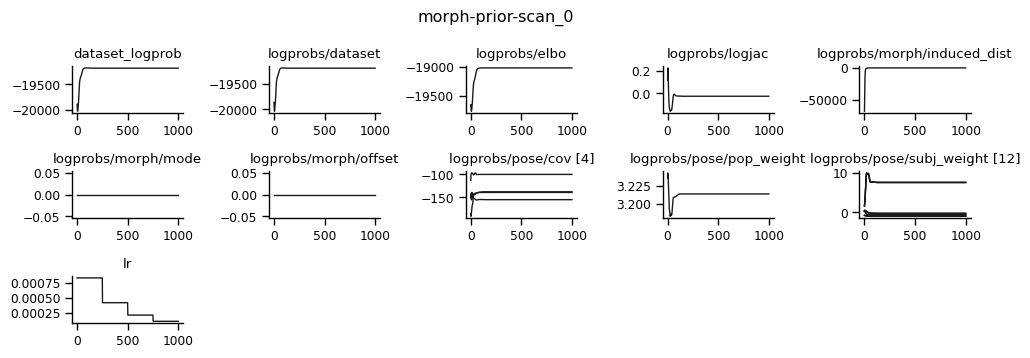

100%|██████████| 1000/1000 [00:00<00:00, 5397.27it/s]


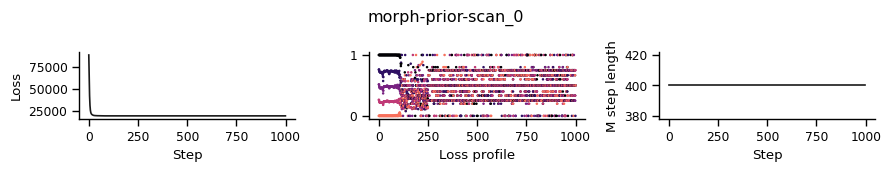

- morph


100%|██████████| 12/12 [00:00<00:00, 56.67it/s]


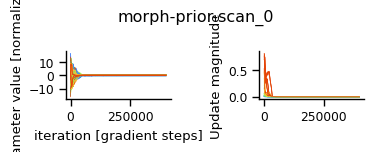

- gmm


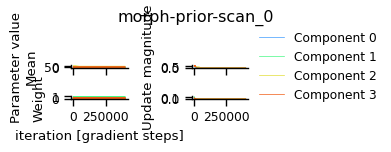

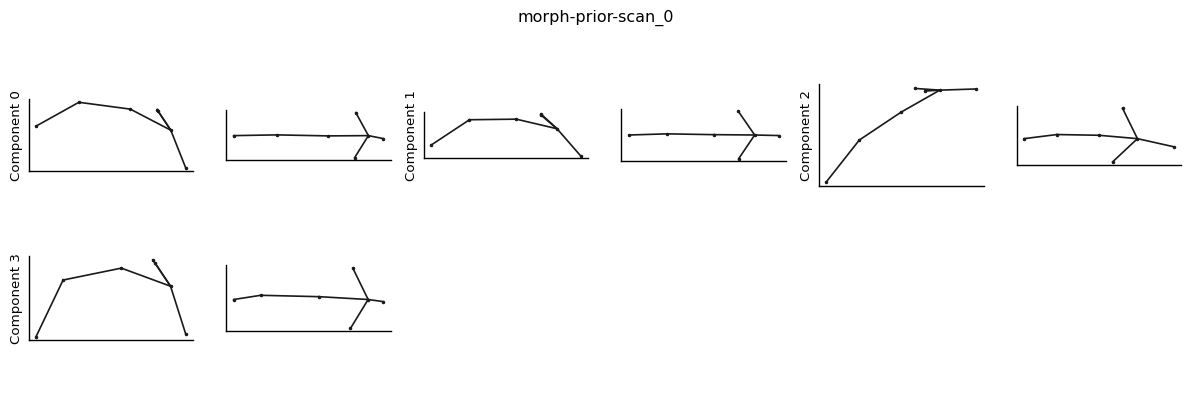

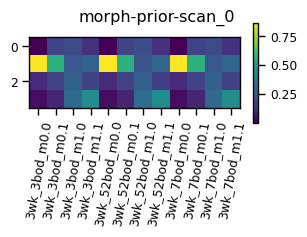

 33%|███▎      | 1/3 [00:02<00:05,  2.84s/it]

Plotting morph-prior-scan_1
- reports


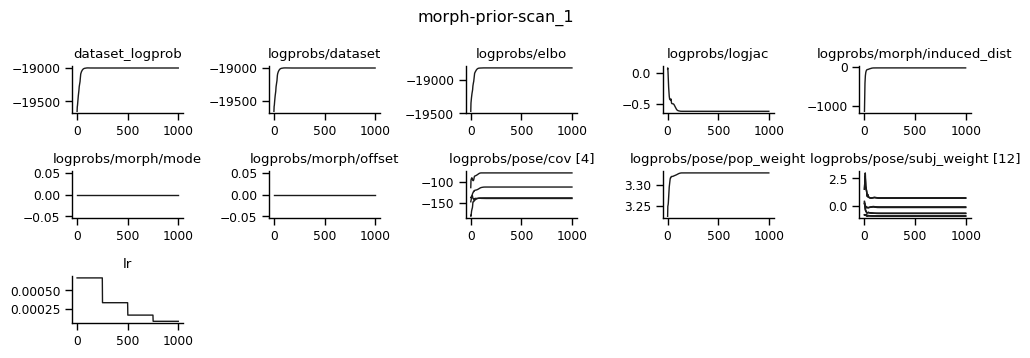

100%|██████████| 1000/1000 [00:00<00:00, 8407.88it/s]


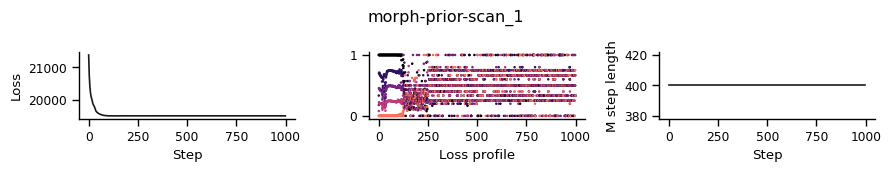

- morph


100%|██████████| 12/12 [00:00<00:00, 84.40it/s]


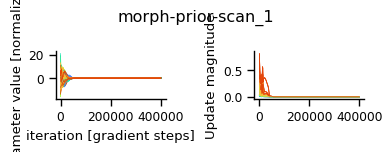

- gmm


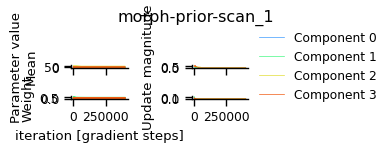

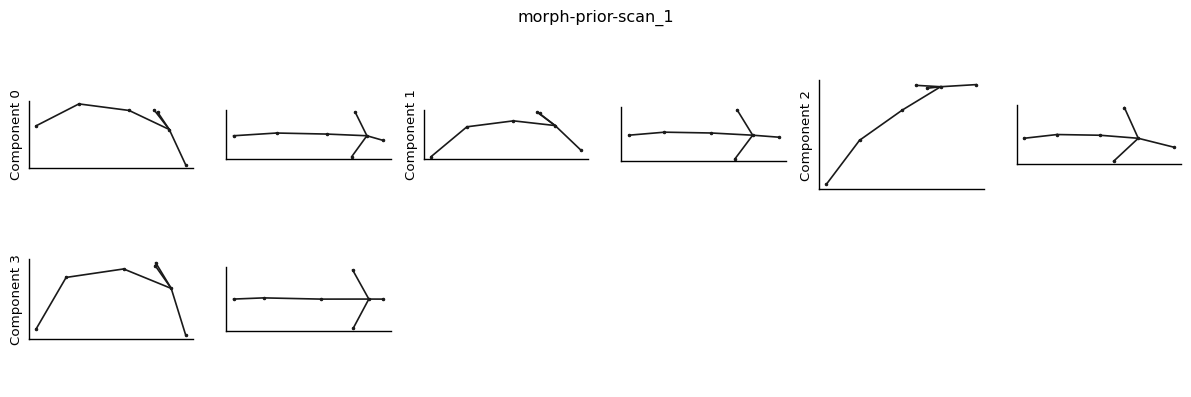

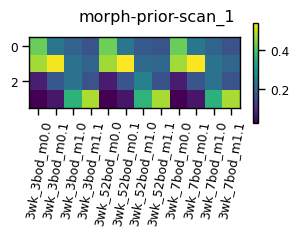

 67%|██████▋   | 2/3 [00:05<00:02,  2.49s/it]

Plotting morph-prior-scan_2
- reports


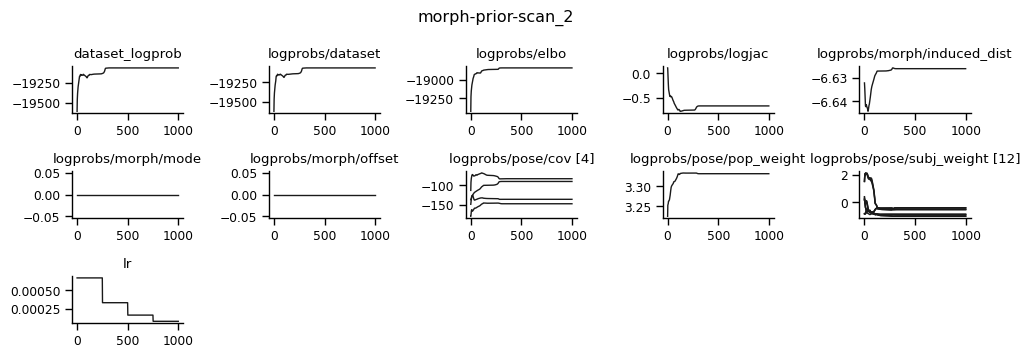

100%|██████████| 1000/1000 [00:00<00:00, 8320.71it/s]


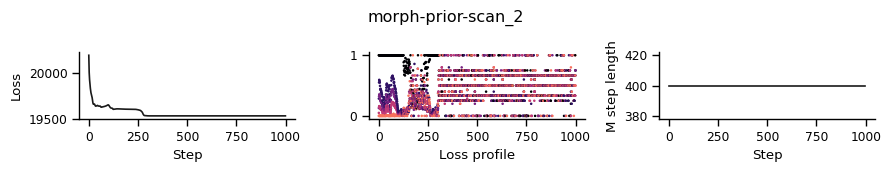

- morph


100%|██████████| 12/12 [00:00<00:00, 180.09it/s]


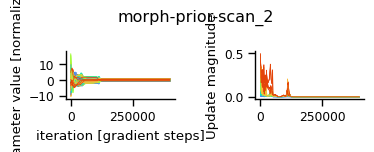

- gmm


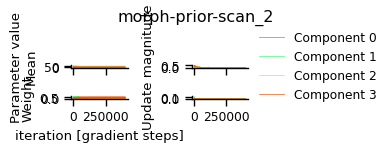

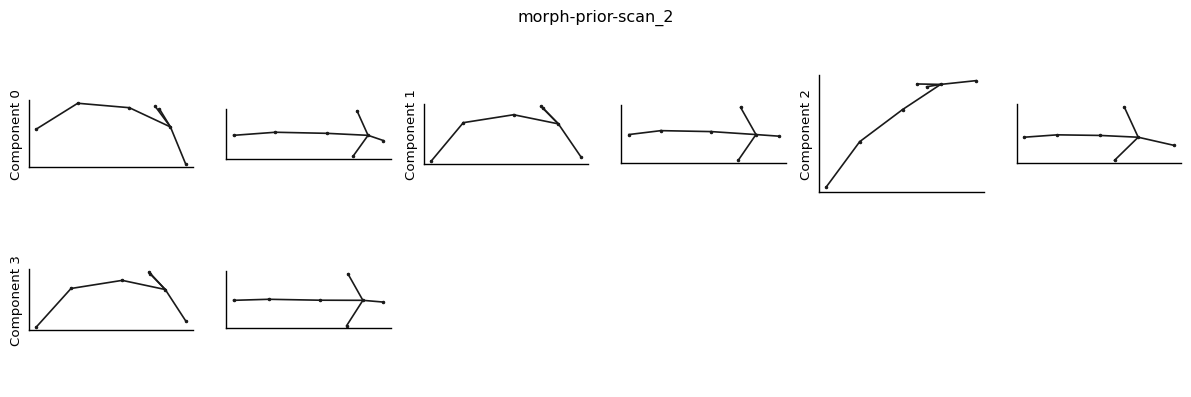

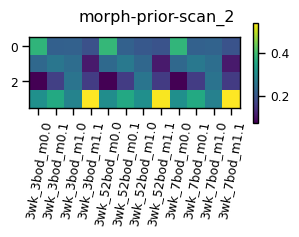

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


In [110]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt, final_mstep=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


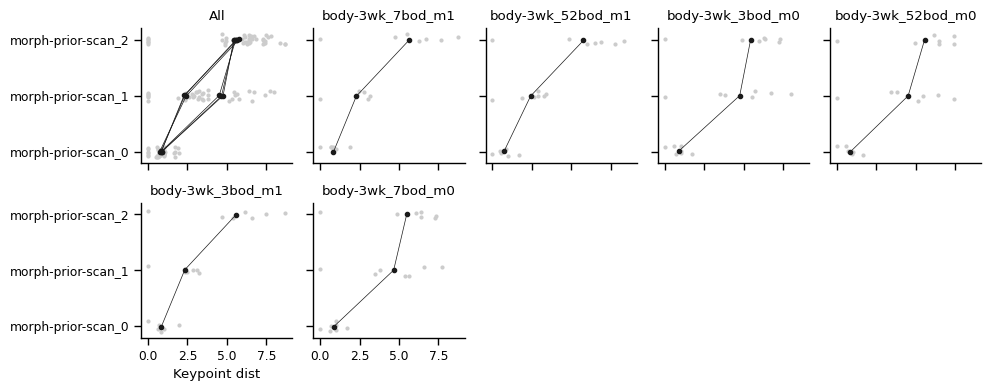

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/blscale-test/3wk-to-07-52/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [111]:
scan_name = "morph-prior-scan"
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = project.scan(scan_name) / "plots"
plotter.finalize(fig, "reconst_errs", path=plot_dir)

Unmorphed: 100%|██████████| 6/6 [00:00<00:00, 1258.92it/s]
/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


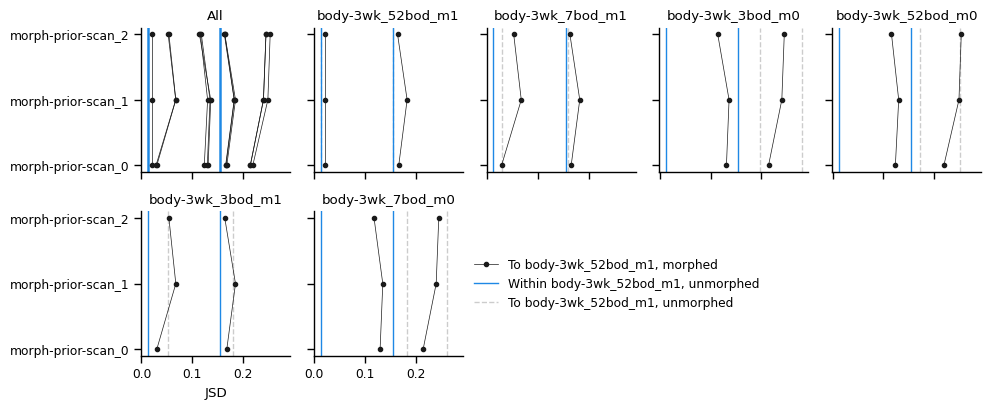

In [112]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

### Dataset specific results

###### 1
Dataset visualization

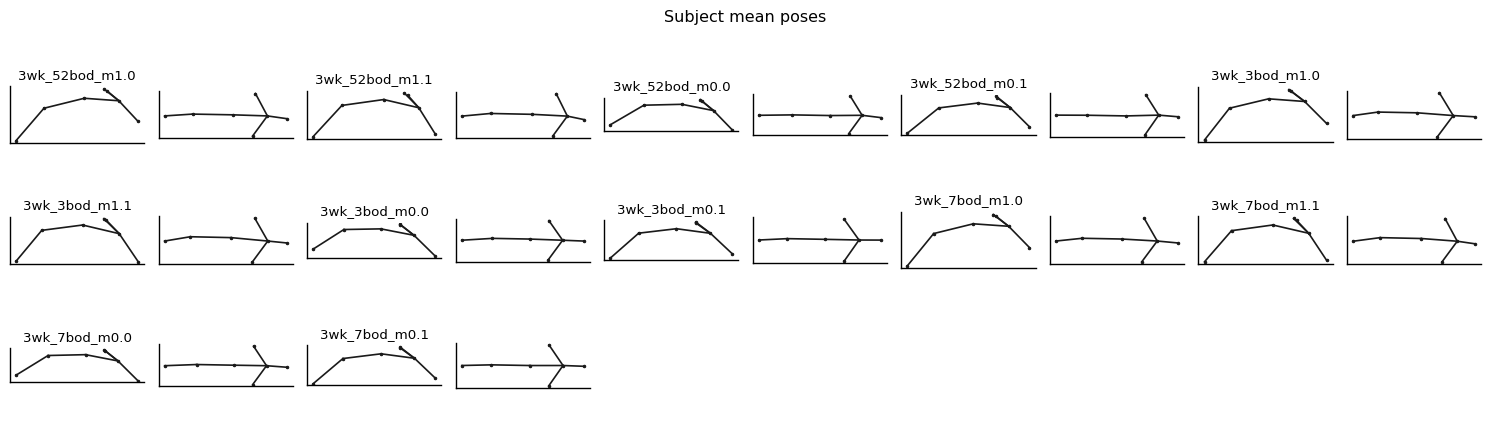

In [50]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

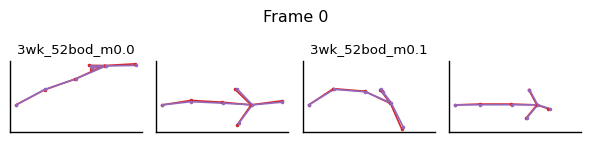

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip([3, 52], [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0', '3wk_3bod_m0.1', '3wk_52bod_m0.1']
cols = [0, 0, 2, 2]
for i, (sess, col) in enumerate(zip(sessions, cols)):
    sess_body = int(re.search(r"(\d+)bod", sess).group(1))
    viz.util.plot_mouse_views(
        ax[(col):col+2],
        inflated.get_session(sess)[0],
        arms, color = session_pal[sess_body], label=sess_body,
    )
    ax[(col)].set_title(sess)
fig.suptitle(f"Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

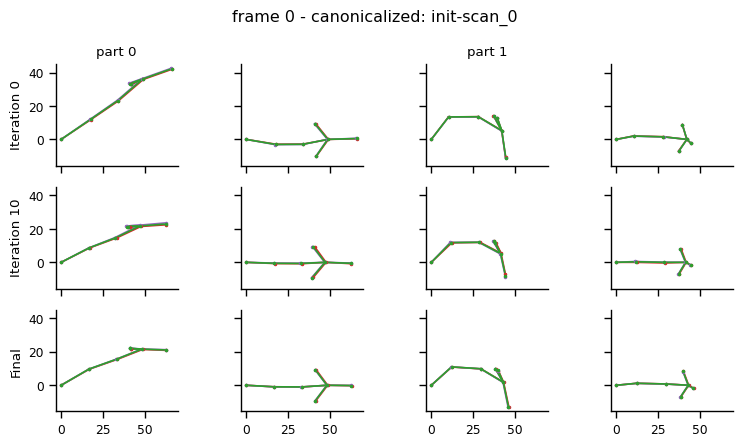

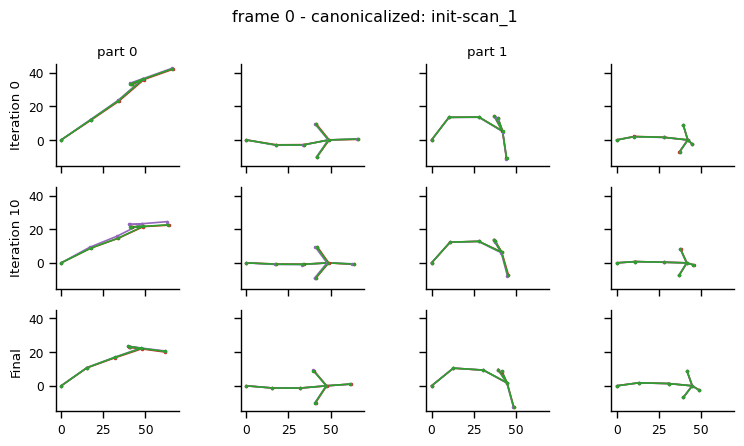

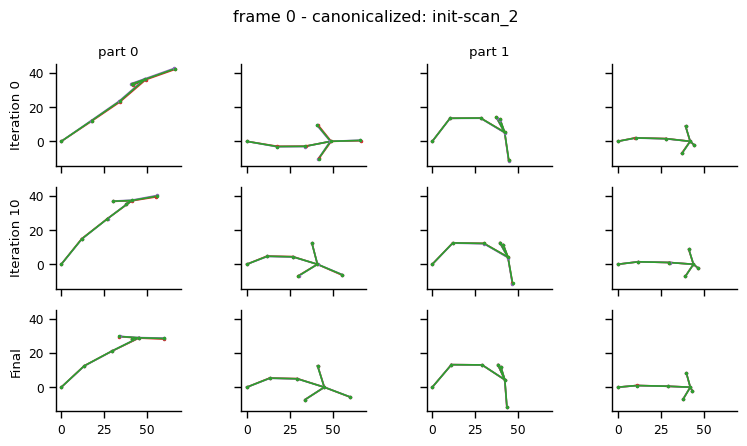

In [19]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    sessions = [s for s in dataset.sessions if s.endswith('m0')]
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1], colors.C[2]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in sessions:
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


###### 4

Framewise keypoint error over training

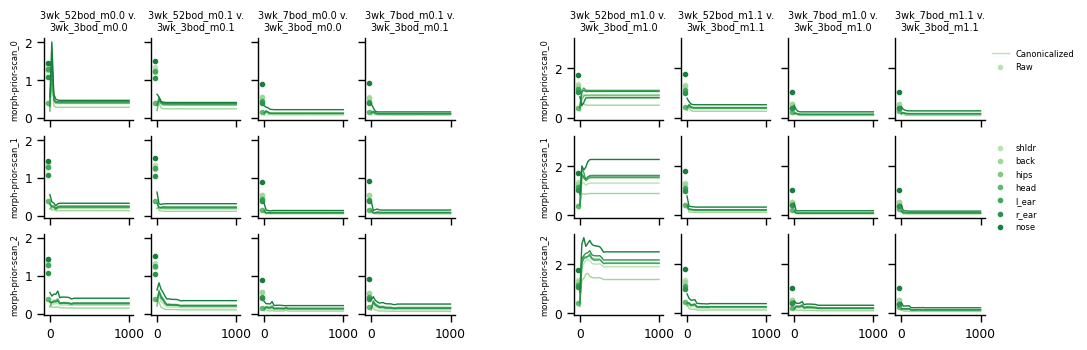

In [61]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())

ncol = len(sessions) * len(parts)
animals = "01"
nanim = len(animals)
n_animcol = min(nanim, 3)
n_animrow = int(np.ceil(nanim / n_animcol))
figure = plt.figure(figsize=((1.2 * ncol) * n_animcol + 1, (1.2 * len(models)) * n_animrow))
_, figs, fig_grid = viz.util.flat_subfig_grid(nanim, n_animcol, fig=figure)
for animal, fig in zip(animals, figs):

    ref_age = '3'
    sessions = [s for s in dataset.sessions if s.endswith(f'm{animal}') and f'{ref_age}bod' not in s]
    pairs = {s: re.sub('(\d+)bod', f'{ref_age}bod', s) for s in sessions}
    parts = "01"

    ax = fig.subplots(len(models), ncol, sharex=True, sharey=True)

    base_errs = {s: [[] for _ in range(len(parts))] for s in sessions}
    inflated = features.inflate(scan_dataset, cfg['features'])
    for i_part, part in enumerate(parts):
        for s in pairs:
            base_errs[s][i_part] = model_util.reconst_errs(
                inflated.get_session(f"{pairs[s]}.{part}"),
                inflated.get_session(f"{s}.{part}"),
                average=False,
            ).mean(axis=0)
    base_errs = {s: np.array(base_errs[s]) for s in sessions}

    for i_mod, model_name in enumerate(models):

        session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

        ckpt = methods.load_fit(project.model(model_name))
        cfg = ckpt["config"]
        max_iter = cfg['fit']['em']['n_steps']
        plot_iters = list(range(0, max_iter - 10, max_iter // 40)) + ['final']
        model = instantiation.get_model(cfg)
        arms = Armature.from_config(cfg["dataset"])
        _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

        errs = {s: [[] for _ in range(len(parts))] for s in sessions}
        for row, plot_iter in enumerate(plot_iters):
            if isinstance(plot_iter, int):
                step_params = scans.select_param_step(
                    model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
                )
            else:
                step_params = ckpt["params"]
            canonicalized = model_util.apply_bodies(
                model.morph,
                step_params.morph,
                scan_dataset,
                {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
            )
            # canonicalized = scan_dataset
            inflated = features.inflate(canonicalized, cfg['features'])

            for s in sessions:
                for i_part, part in enumerate(parts):
                    errs[s][i_part].append(model_util.reconst_errs(
                        inflated.get_session(f"{pairs[s]}.{part}"),
                        inflated.get_session(f"{s}.{part}"),
                        average=False,
                    ).mean(axis=0))
        errs = {s: np.array(errs[s]) for s in sessions}

        for i_s, s in enumerate(sessions):
            for i_part, part in enumerate(parts):
                i_col = i_s * len(parts) + i_part
                for i_kp in range(errs[s].shape[-1]):
                    if cfg["dataset"]["use_keypoints"][i_kp] == 'hips':
                        continue
                    ax[i_mod, i_col].plot(_x, errs[s][i_part, :, i_kp], color=kp_colors[i_kp], lw = 1, ms = 0, label = "Canonicalized")
                    ax[i_mod, i_col].plot([-_x[1]], [base_errs[s][i_part, i_kp]], 'o', color=kp_colors[i_kp], lw = 0, ms = 3, label = "Raw")
                ax[i_mod, 0].set_ylabel(model_name, fontsize = 6)
                ax[0, i_col].set_title(f"{s}.{part} v.\n{pairs[s]}.{part}", fontsize = 7)
    
    for a in ax.ravel():
        sns.despine(ax=a)
    
    if fig is fig_grid[0, -1]:
        kp_artists = [
            ax[1, -1].plot([np.nan], [np.nan], 'o', color=kp_colors[i_kp], ms = 3, label = cfg["dataset"]["use_keypoints"][i_kp])[0]
            for i_kp in range(errs[sessions[0]].shape[-1])
        ]
        kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[1, -1].get_legend_handles_labels()) if h in kp_artists])

        ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0.5,), fontsize = 6, frameon=False)
        ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)

    # plt.tight_layout()
    
# figure.tight_layout()
plotter.finalize(figure, None, tight=False, despine=False)


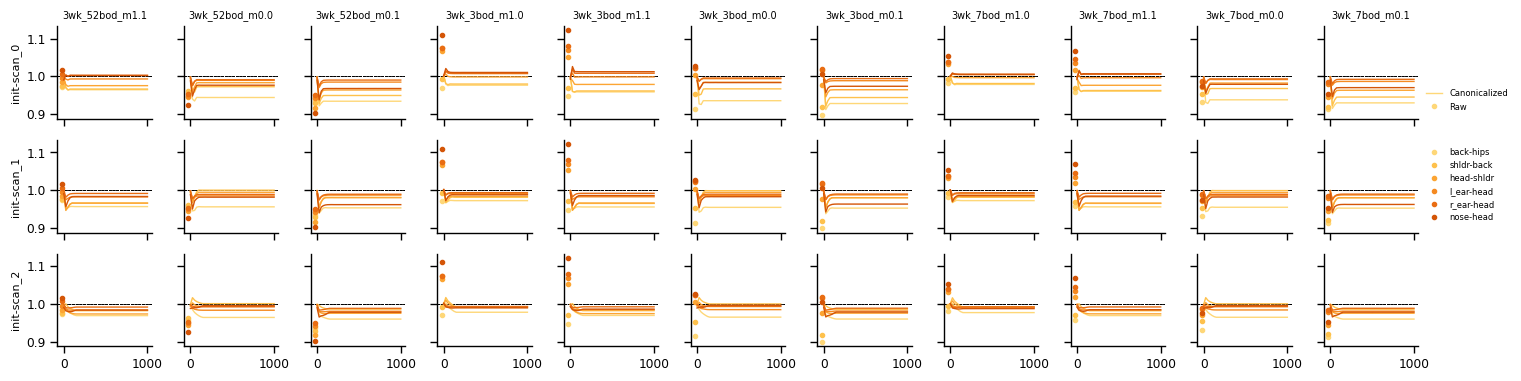

In [42]:
# bone length over training

# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
bo_colors = Colormap('whorbr')(np.linspace(0.3, 0.8, n_kpt))

models = list(scan_cfg['models'].keys())
parts = "01"

cfg = config.load_project_config(project.main_config())
arms = Armature.from_config(cfg["dataset"])
_bone_lengths = lambda kpts, arms: jnp.linalg.norm(kpts[:, arms.bones[:, 0]] - kpts[:, arms.bones[:, 1]], axis=-1)
_bone_name = lambda i: f"{arms.keypoint_names[int(arms.bones[i, 0])]}-{arms.keypoint_names[int(arms.bones[i, 1])]}"
bone_names = [_bone_name(i) for i in range(arms.bones.shape[0])]
inflated = features.inflate(scan_dataset, cfg['features'])
base_bls = _bone_lengths(inflated.get_session(scan_dataset.ref_session), arms).mean(axis=0)
base_rtos = {
    s: _bone_lengths(inflated.get_session(s), arms).mean(axis=0) / base_bls
    for s in scan_dataset.sessions
}
sessions = [s for s in scan_dataset.sessions if scan_dataset.session_id(s) != scan_dataset.ref_session]


fig, ax = plt.subplots(len(models), len(sessions), figsize=(1.3 * len(sessions) + 1, 1.3 * len(models)), sharex=True, sharey = True)

for i_mod, model_name in enumerate(models):

    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    max_iter = cfg['fit']['em']['n_steps']
    plot_iters = list(range(0, max_iter - 10, max_iter // 40)) + ['final']
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    _x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

    bls = {s: [] for s in sessions}
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for s in bls:
            bls[s].append(_bone_lengths(inflated.get_session(s), arms).mean(axis=0))
    bls = {k: np.array(a) for k, a in bls.items()}
    

    for i_s, s in enumerate(bls):
        for i_b, b_name in enumerate(bone_names):
            ax[i_mod, i_s].plot(_x, bls[s][:, i_b] / base_bls[i_b], color=bo_colors[i_b], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_mod, i_s].plot([-_x[1]], [base_rtos[s][i_b]], 'o', color=bo_colors[i_b], lw = 0, ms = 3, label = "Raw")
            ax[i_mod, i_s].axhline(1., color = 'k', lw = 0.5, ls = '--', zorder = -1)
        ax[i_mod, 0].set_ylabel(model_name, fontsize = 8)
        ax[0, i_s].set_title(s, fontsize = 7)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=bo_colors[i_b], ms = 3, label = b_name)[0]
    for i_b, b_name in enumerate(bone_names)
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


## More than two target ages

Export dataset with all animals and target ages

### Project and dataset setup

In [24]:
# save out blscale data
if False:
    blscale_arrays_dir = Path("/Users/kaifox/projects/mph/data_explore/testsets/blscale-arrays/3wk-to-all_ntt-norm")

    blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
    data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

    base = '3'
    source_dict = blscale_dir / "source-dicts" / "cohort-wise" / f"{base}wk-to-all.yaml"
    scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"

    project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')
    _, _, bones, root = raw_data_armature_meta()

    for s in dataset_keypoints:
        np.save(blscale_arrays_dir / f"{s}.npy", dataset_keypoints[s])
    
    YAML().dump({
        "source_dict_path": str(source_dict),
        "scale_dict_path": str(scale_dict),
        "source_dict": YAML(typ='safe').load(source_dict),
        "scale_dict": YAML(typ='safe').load(scale_dict),
        "applied_scales": scales,
        "armature": {'bones': bones.tolist(), 'root': root},
        "project_config_kws": project_config_kws,
    }, open(blscale_arrays_dir / "metadata.yml", 'w'))

Loading keypoints: 100%|█████████████████| 4/4 [00:00<00:00, 741.86it/s]


Sessions: ['3wk_5bod_m1', '3wk_5bod_m0', '3wk_5bod_m2', '3wk_5bod_m3', '3wk_72bod_m1', '3wk_72bod_m0', '3wk_72bod_m2', '3wk_72bod_m3', '3wk_52bod_m1', '3wk_52bod_m0', '3wk_52bod_m2', '3wk_52bod_m3', '3wk_24bod_m1', '3wk_24bod_m0', '3wk_24bod_m2', '3wk_24bod_m3', '3wk_3bod_m1', '3wk_3bod_m0', '3wk_3bod_m2', '3wk_3bod_m3', '3wk_7bod_m1', '3wk_7bod_m0', '3wk_7bod_m2', '3wk_7bod_m3']


In [43]:
blscale_arrays_dir = Path("/Users/kaifox/projects/mph/data_explore/testsets/blscale-arrays")

ref_age = "3"
tgt_ages = ["7", "52"]
animals = ["0", "1"]
sessions = [
    f"{ref_age}wk_{t}bod_m{a}" for a in animals for t in [ref_age] + tgt_ages
]
names, parents, _, _ = raw_data_armature_meta()
project_config_kws = dict(
    filepaths = {s: blscale_arrays_dir / f"{s}.npy" for s in sessions},
    keypoint_names = names,
    keypoint_parents = parents,
    bodies = {s: f"body-{s}" for s in sessions},
    ref_session = f"{ref_age}wk_52bod_m1",
)

print(sessions)

['3wk_3bod_m0', '3wk_7bod_m0', '3wk_52bod_m0', '3wk_3bod_m1', '3wk_7bod_m1', '3wk_52bod_m1']


In [44]:
# Create base project config to override

project_dir = Path('../projects/blscale-test/3wk-to-07-52-npyloader')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



### Calibration and training

In [45]:
loaders.raw_npy.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=200,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.load_dataset(cfg['dataset'])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["pose"]["subj_weight_uniformity"] = 1
cfg["fit"]["n_steps"] = 1000
cfg["fit"]["learning_rate"] = dict(kind='stair', hl = 250, lr = 5e-1, min = 1e-5)
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["update_scales"] = {'pose/*': 1e1}

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames
INFO:root:Fitting GMM to 200 frames


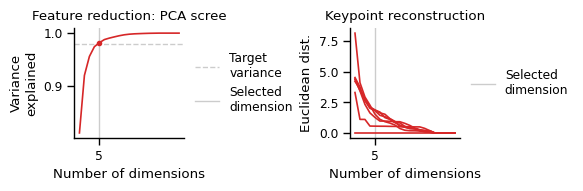

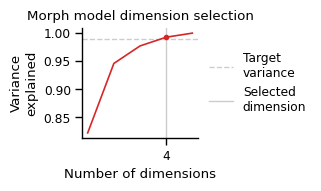

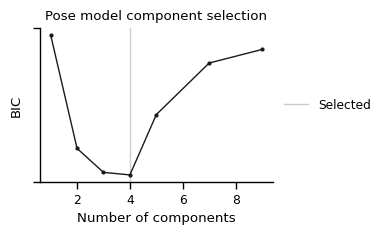

PosixPath('../projects/blscale-test/3wk-to-07-52-npyloader/plots/pose_calibration.pdf')

In [46]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

###### scan setup

define scans to test various configurations

In [ ]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate.lr': [1e0, 8e-1, 8e-1],
    'fit.em.n_steps': [1000, 1000, 1000],
})

scan_cfg, model_cfg = scans.setup_scan_config(project, "init-scan", {
    'morph.dist_var': [1e-1, 8e-1, 3e2],
    'fit.em.learning_rate.lr': [1e0, 8e-1, 8e-1],
    'fit.em.n_steps': [1000, 1000, 1000],
    'morph.init.type': ['covariance', 'covariance', 'covariance'],
})

In [ ]:
cfg = config.load_project_config(project.main_config())
scan_cfg = config.load_config(project.scan('morph-prior-scan') / 'scan.yml')
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

## Panels

#### Setup

Load blscale dataset, select `shape_norm`, project, choose a model name and load
the corresponding dataset.

In [114]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "cohort-wise" / f"{base}wk-to-all.yaml"
# scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"
scale_dict = blscale_dir / "scale-dicts" / f"all-to-named-age_unnormed.yaml"

project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')


Loading keypoints: 100%|█████████████████| 4/4 [00:00<00:00, 351.87it/s]


Sessions: ['3wk_5bod_m1', '3wk_5bod_m0', '3wk_5bod_m2', '3wk_5bod_m3', '3wk_72bod_m1', '3wk_72bod_m0', '3wk_72bod_m2', '3wk_72bod_m3', '3wk_52bod_m1', '3wk_52bod_m0', '3wk_52bod_m2', '3wk_52bod_m3', '3wk_24bod_m1', '3wk_24bod_m0', '3wk_24bod_m2', '3wk_24bod_m3', '3wk_3bod_m1', '3wk_3bod_m0', '3wk_3bod_m2', '3wk_3bod_m3', '3wk_7bod_m1', '3wk_7bod_m0', '3wk_7bod_m2', '3wk_7bod_m3']


In [115]:
# Select `shape_norm` project directory and metadata about the project

project_dir = Path('../projects/blscale-test/3wk-to-07-52')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = Path("../../../data_explore/plots/notebook/small-blscale")
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf', transparent = True, dpi=1200)

ref_age = '3'
tgt_age = '52'
scale_to = f"{ref_age}wk_{ref_age}bod_m0.0"
tgt_ages = ['7', '52']
ref_color = getc('deep:180')
tgt_color = getc('deep:70')
tgt_colors = [getc('deep:120'), getc('deep:70')]


In [129]:
# Select and load model

scan_name = 'morph-prior-scan'
model_name = 'morph-prior-scan_0'

ckpt = methods.load_fit(project.model(model_name))
cfg = ckpt["config"]
model = instantiation.get_model(cfg)
arms = Armature.from_config(cfg["dataset"])
params = ckpt["params"]

dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, align_meta = scans.prepare_scan_dataset(dataset, project, scan_name, return_session_inv=True)

In [688]:
plt.rcParams.update({
    # font
    'font.family': 'Arial',
    'font.size': 6,
    'axes.labelsize': 6,
    'xtick.labelsize': 5.5,
    'ytick.labelsize': 5.5,
    'axes.titlesize': 6,
    'legend.fontsize': 5.5,
    'figure.titlesize': 6,
    # axes
    'axes.facecolor': 'ffffff00',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.25,
    'xtick.major.width': 0.2,
    'ytick.major.width': 0.2,
    'xtick.minor.width': 0.15,
    'ytick.minor.width': 0.15,
    'xtick.major.pad': 1.5,
    'ytick.major.pad': 1.5,
    'xtick.major.size': 1.2,
    'ytick.major.size': 1.2,
    'xtick.minor.size': 1,
    'ytick.minor.size': 1,
    # legend
    'legend.frameon': False,
    # misc
    'hatch.linewidth': 0.5,
})

#### supporting functions

In [167]:
def canonicalized_and_raw(dataset, params, base_dataset=None, rescale=True, scale_to=None):
    canonicalized = model_util.apply_bodies(
        model.morph,
        params.morph,
        dataset,
        {
            s: dataset.session_body_name(dataset.ref_session)
            for s in dataset.sessions
        },
    )
    canonicalized = features.inflate(canonicalized, cfg["features"])
    raw = features.inflate(dataset, cfg["features"])

    if rescale:
        raw, split_align_meta = unalign_scales(
            align_meta, raw, split_meta, base_dataset
        )
        align_to = split_align_meta["scale"][dataset.session_id(scale_to)]
        canonical_meta = {"scale": np.full(dataset.n_sessions, align_to)}
        canonicalized, _ = unalign_scales(canonical_meta, canonicalized)
    return canonicalized, raw, (split_align_meta if rescale else {})


def canonicalized_raw_bls(
    canonicalized, raw, sessions, parts="01", group_bodies=True
):
    groups = (
        {s: re.search(r"(\d+)bod", s).group(1) for s in sessions}
        if group_bodies
        else {s: s for s in sessions}
    )
    bls_canon = {g: [] for g in set(groups.values())}
    bls_raw = {g: [] for g in set(groups.values())}
    for s in sessions:
        k = groups[s]
        bls_canon[k].extend(
            [
                _bone_lengths(canonicalized.get_session(f"{s}.{part}"), arms)
                for part in parts
            ]
        )
        bls_raw[k].extend(
            [
                _bone_lengths(raw.get_session(f"{s}.{part}"), arms)
                for part in parts
            ]
        )
    bls_canon = {k: jnp.concatenate(v) for k, v in bls_canon.items()}
    bls_raw = {k: jnp.concatenate(v) for k, v in bls_raw.items()}
    return bls_canon, bls_raw, groups


cfg = config.load_project_config(project.main_config())
arms = Armature.from_config(cfg["dataset"])
_bone_lengths = lambda kpts, arms: jnp.linalg.norm(
    kpts[..., arms.bones[:, 0], :] - kpts[..., arms.bones[:, 1], :], axis=-1
)
_bone_name = (
    lambda i: f"{arms.keypoint_names[int(arms.bones[i, 0])]}-{arms.keypoint_names[int(arms.bones[i, 1])]}"
)
bone_names = [_bone_name(i) for i in range(arms.bones.shape[0])]

In [119]:
def indiv_holdout(feats, groups, seed, shuffle):
    rng = np.random.default_rng(seed)
    feat_val = []
    feat_trn = []
    tgt_val = []
    tgt_trn = []
    tgt_keys = dict(zip(groups.keys(), range(len(groups))))
    for grp_key, grp in groups.items():
        holdout = rng.integers(len(grp))
        feat_val.append(feats[grp[holdout]])
        feat_trn.extend([feats[s] for i, s in enumerate(grp) if i != holdout])
        lens = [len(feats[s]) for s in grp]
        tgt_val.append(np.full(lens[holdout], tgt_keys[grp_key]))
        tgt_trn.extend([np.full(l, tgt_keys[grp_key]) for i, l in enumerate(lens) if i != holdout])
    feat_val = np.concatenate(feat_val, axis = 0)
    feat_trn = np.concatenate(feat_trn, axis = 0)
    tgt_val = np.concatenate(tgt_val, axis = 0)
    tgt_trn = np.concatenate(tgt_trn, axis = 0)
    if shuffle:
        tgt_trn = rng.permutation(tgt_trn)
    return feat_trn, feat_val, tgt_trn, tgt_val

def frame_holdout(feats, groups, seed, shuffle, train_pct = 0.8):
    rng = np.random.default_rng(seed)
    feat_val = []
    feat_trn = []
    tgt_val = []
    tgt_trn = []
    tgt_keys = dict(zip(groups.keys(), range(len(groups))))
    for grp_key, grp in groups.items():
        for s in grp:
            x = feats[s]
            trn, val = np.split(rng.permutation(len(x)), [int(train_pct * len(x))])
            feat_trn.append(x[trn])
            feat_val.append(x[val])
            tgt_trn.append(np.full(len(trn), tgt_keys[grp_key]))
            tgt_val.append(np.full(len(val), tgt_keys[grp_key]))
    feat_val = np.concatenate(feat_val, axis = 0)
    feat_trn = np.concatenate(feat_trn, axis = 0)
    tgt_val = np.concatenate(tgt_val, axis = 0)
    tgt_trn = np.concatenate(tgt_trn, axis = 0)
    if shuffle:
        tgt_trn = rng.permutation(tgt_trn)
    return feat_trn, feat_val, tgt_trn, tgt_val

def pairwise_group_acc(feats, groups, ref, nonref, n_iter = 40):
    scores = {a: [] for a in nonref}
    scores_null = {a: [] for a in nonref}
    for is_null, scores_dict in enumerate([scores, scores_null]):
        for nonref_age in tqdm.tqdm(nonref):
            for seed in range(n_iter):
                xt, xv, yt, yv = indiv_holdout(
                    feats,
                    {ref: groups[ref], nonref_age: groups[nonref_age]},
                    seed,
                    shuffle = is_null
                )
                model = LogisticRegression(max_iter=1000, class_weight="balanced")
                scores_dict[nonref_age].append(model.fit(xt, yt).score(xv, yv))
    return scores, scores_null

def allway_group_acc(feats, groups, n_iter = 40, subsample = 1, clf_kws = {}, prescale = False):
    scores_list = [[], []]
    for is_null in range(2):
        for seed in tqdm.trange(n_iter):
            xt, xv, yt, yv = indiv_holdout(
                {k: v[::subsample] for k, v in feats.items()},
                groups,
                seed,
                shuffle = is_null
            )
            if prescale:
                m, sd = xt.mean(axis = 0), xt.std(axis = 0)
                xt = (xt - m) / sd
                xv = (xv - m) / sd
            model = LogisticRegression(**{**dict(max_iter=1000, class_weight="balanced"), **clf_kws})
            scores_list[is_null].append(model.fit(xt, yt).score(xv, yv))
    return scores_list

def pairwise_framewise_acc(feats, groups, n_iter = 1):
    scores_list = [[], [], [], []]
    combos = list(iit.combinations(groups.keys(), 2)) + [(k, k) for k in groups.keys()]
    for g1, g2 in tqdm.tqdm(combos):
        within_group = g1 == g2
        for is_null in range(2 if not within_group else 1):
            for i, (s1, s2) in enumerate(iit.product(groups[g1], groups[g2])):
                within_animal = s1 == s2
                for seed in range(n_iter):
                    xt, xv, yt, yv = frame_holdout(
                        feats,
                        {'s1': [s1], 's2': [s2]},
                        i * (seed + i),
                        shuffle = is_null
                    )
                model = LogisticRegression(max_iter=1000, class_weight="balanced")
                score_ix = 3 if within_animal else (2 if within_group else is_null)
                scores_list[score_ix].append(model.fit(xt, yt).score(xv, yv))
    return scores_list


#### 1. Anchor poses

First and second anchor poses of 3wk and 52wk animals.

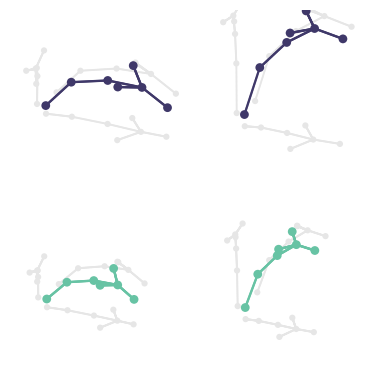

In [29]:
scan_align_meta = {'scale': np.array([-1. for _ in scan_dataset.sessions])}
for src_sess, splits in split_meta[1].items():
    for s in splits:
        scan_align_meta['scale'][scan_dataset.session_id(s)] = align_meta['scale'][dataset.session_id(src_sess)]

anchors = anchor_keypoints(
    params.morph,
    scan_align_meta,
    magnitudes=anchor_magnitudes(scan_dataset, params.morph, q = 0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)

fig, ax = plt.subplots(2, 2, figsize = (4, 4), subplot_kw = dict(projection='3d'))
kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c: [
    plot_mouse_3d(f, a, **kws(c, 40, 3)),
    plot_mouse_3d(dropz(f, -5), a, **kws('.9', 20, 2)),
    plot_mouse_3d(dropy(f, 15), a, **kws('.9', 20, 2)),
    plot_mouse_3d(dropx(f, -5), a, **kws('.9', 20, 2)),
]

ref_body = scan_dataset.session_body_id(f'{ref_age}wk_{ref_age}bod_m0.0')
tgt_body = scan_dataset.session_body_id(f'{ref_age}wk_{tgt_age}bod_m0.0')
for a in ax.ravel():
    a.sharex(ax[0, 0])
    a.sharey(ax[0, 0])
    a.sharez(ax[0, 0])

plotdrop(anchors[ref_body, 1], ax[1, 1], ref_color)
plotdrop(anchors[tgt_body, 1], ax[0, 1], tgt_color)
plotdrop(anchors[ref_body, 0], ax[1, 0], ref_color)
plotdrop(anchors[tgt_body, 0], ax[0, 0], tgt_color)
plotter.finalize(fig, None)

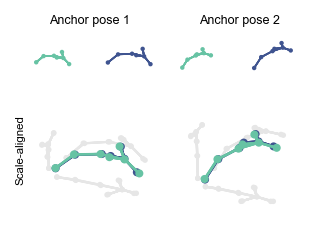

PosixPath('../../../data_explore/plots/notebook/small-blscale/anchor-pose-examples.pdf')

In [726]:
scan_align_meta = {'scale': np.array([-1. for _ in scan_dataset.sessions])}
for src_sess, splits in split_meta[1].items():
    for s in splits:
        scan_align_meta['scale'][scan_dataset.session_id(s)] = align_meta['scale'][dataset.session_id(src_sess)]

anchors = anchor_keypoints(
    params.morph,
    {},
    magnitudes=anchor_magnitudes(scan_dataset, params.morph, q = 0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)
anchors_scaled = anchor_keypoints(
    params.morph,
    scan_align_meta,
    magnitudes=anchor_magnitudes(scan_dataset, params.morph, q = 0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)


kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, lsm=1, shad=True, dropax=None: [
    plot_mouse_3d(f, a, **kws(c, sm * 15, 1.5 * lsm))
    ] + [
    dropax := dropax if dropax is not None else a,
    ] + ([
    plot_mouse_3d(dropz(f, -5), dropax, **kws('.9', sm * 7, 1 * lsm)),
    plot_mouse_3d(dropy(f, 15), dropax, **kws('.9', sm * 7, 1 * lsm)),
    plot_mouse_3d(dropx(f, -5), dropax, **kws('.9', sm * 7, 1 * lsm)),
] if shad else [])

gs = plt.GridSpec(2, 4, height_ratios=[1, 2])
fig = plt.figure(figsize=(2, 1.5), dpi=150)
row0 = np.array([fig.add_subplot(gs[0, i], projection='3d') for i in range(4)])
row1 = np.array([fig.add_subplot(gs[1, 2*i:2*i+2], projection='3d') for i in range(2)])
row2 = np.array([fig.add_subplot(gs[1, 2*i:2*i+2], projection='3d') for i in range(2)])
row3 = np.array([fig.add_subplot(gs[1, 2*i:2*i+2], projection='3d') for i in range(2)])

ref_body = scan_dataset.session_body_id(f'{ref_age}wk_{ref_age}bod_m0.0')
tgt_body = scan_dataset.session_body_id(f'{ref_age}wk_{tgt_age}bod_m0.0')
for a, b in zip(row0[::2], row0[1::2]):
    b.sharex(a)
    b.sharey(a)
    b.sharez(a)
for a, b, c in zip(row1, row2, row3):
    b.sharex(a)
    b.sharey(a)
    b.sharez(a)
    c.sharex(a)
    c.sharey(a)
    c.sharez(a)
    a.set_facecolor((0, 0, 0, 0))
    b.set_facecolor((0, 0, 0, 0))
    c.set_facecolor((0, 0, 0, 0))

plotdrop(anchors_scaled[ref_body, 0], row0[0], ref_color, 0.3, 0.5, False)
plotdrop(anchors_scaled[tgt_body, 0], row0[1], tgt_color, 0.3, 0.5, False)
plotdrop(anchors_scaled[ref_body, 1], row0[2], ref_color, 0.3, 0.5, False)
plotdrop(anchors_scaled[tgt_body, 1], row0[3], tgt_color, 0.3, 0.5, False)
plotdrop(anchors[ref_body, 0], row3[0], ref_color, dropax=row1[0])
plotdrop(anchors[tgt_body, 0], row2[0], tgt_color, dropax=row1[0])
plotdrop(anchors[ref_body, 1], row3[1], ref_color, dropax=row1[1])
plotdrop(anchors[tgt_body, 1], row2[1], tgt_color, dropax=row1[1])

fig.text(0.25, 1, 'Anchor pose 1', ha='center', va='top')
fig.text(0.75, 1, 'Anchor pose 2', ha='center', va='top')
fig.text(0.02, 0.4, "Scale-aligned", ha = 'center', va = 'center', rotation=90, size=5.5)

plotter.finalize(fig, 'anchor-pose-examples')
# plotter.finalize(fig, None)

#### 2. Anchor poses recapitulate the applied bone scales

Why is the applied scale 0.9 for 3wk_52bod_m0 and 1.1 for 3wk_52bod_m1? I could
imagine them being a little different, but not this different!

In particular the rigid scaling should have taken care of this.

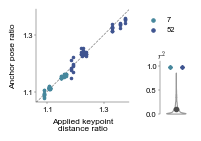

PosixPath('../../../data_explore/plots/notebook/small-blscale/anchor-poses-bls-vs-applied.pdf')

In [725]:
rescale = True
sessions = dataset.sessions
parts = "01"
pairs = {
    s: re.sub(r"\d+bod", f"{ref_age}bod", s)
    for s in sessions
    if not f"{ref_age}bod" in s
}

# ---- get rescaled raw data and anchor poses, compute paired bone length ratios

_, raw, scan_align_meta = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
anchors = anchor_keypoints(  # shape (n_session, n_anchor, n_kpt, 3)
    params.morph,
    scan_align_meta if rescale else {},
    magnitudes=anchor_magnitudes(scan_dataset, params.morph, q=0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)

raw_bls = {
    s: np.concatenate(
        [_bone_lengths(raw.get_session(f"{s}.{part}"), arms) for part in parts]
    )
    for s in sessions
}
raw_ratios = {s: raw_bls[s] / raw_bls[pairs[s]] for s in pairs}

anchor_bls = {
    s: np.mean(
        [_bone_lengths(anchors[scan_dataset.session_id(f"{s}.{part}")], arms) for part in parts],
        axis = 0
    )
    for s in sessions
}
anchor_ratios = {s: anchor_bls[s] / anchor_bls[pairs[s]] for s in pairs}

groups = {re.search(r"(\d+)bod", s).group(1) for s in pairs}
groups = {g: [s for s in sessions if re.search(r"(\d+)bod", s).group(1) == g] for g in groups}
corr = lambda x, y: np.corrcoef(np.array(x).ravel(), np.array(y).ravel())[0, 1] ** 2
groupwise_r2 = {
    g: corr([raw_ratios[s].mean(axis = 0) for s in groups[g]], [anchor_ratios[s].mean(axis = 0) for s in groups[g]])
    for g in groups
}
rng = np.random.default_rng(1032)
shuf_r2 = np.array([
    [corr([raw_ratios[s].mean(axis = 0) for s in groups[g]], [rng.permutation(anchor_ratios[s].mean(axis = 0)) for s in groups[g]])
     for _ in range(1000)]
    for g in groups
]).ravel()


# --- plot ratio in raw vs ratio in anchor poses
fig = plt.figure(figsize=(2., 1.5))
gs = plt.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 1], wspace=0.5)
ax = fig.add_subplot(gs[:, 0])
r2_ax = fig.add_subplot(gs[1, 1])
for s in pairs:
    group = re.search(r"(\d+)bod", s).group(1)
    group_pal = {ref_age: ref_color, **{a: c for a, c in zip(tgt_ages, tgt_colors)}}
    anchor_pal = Colormap('husl')(np.linspace(0, 1, anchors.shape[1]))
    for i_a in range(anchors.shape[1]):
        ax.scatter(raw_ratios[s].mean(axis = 0), anchor_ratios[s][i_a], color=group_pal[group], s=3, label=group)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
min_, max_ = min(xmin, ymin), max(xmax, ymax)
ax.set_xlim(min_, max_)
ax.set_ylim(min_, max_)
ax.plot([min_, max_], [min_, max_], color='.5', lw=0.5, ls='--', zorder=-1, )
ax.set_aspect(1.)
ax.set_ylabel("Anchor pose ratio")
ax.set_yticks([1.1, 1.3])
ax.set_xticks([1.1, 1.3])
ax.set_xlabel("Applied keypoint\ndistance ratio")
hl = zip(*sorted(zip(*viz.util.unique_handles(ax)), key=lambda x: int(x[1])))
leg = viz.util.legend(ax, hl, loc='upper left', bbox_to_anchor=(1.1, 1.), frameon=False)
for h in leg.legend_handles:
    h.set_sizes([6])

viz.util.grouped_violins(
    [[shuf_r2]],
    bw = 0.01,
    ax = r2_ax,
    x = [0.5],
    colors='.3',
    width=1,
    bw_buffer=0,
    fill_kw=dict(ec='.6'),
    # jitter=0.5,
    # offset=False,
    # lighten_points=0.8,
    # points_kw = dict(ms=1),
    error=lambda x: viz.util.ci(x, np.nanmean, 0.95),
)
for x, g, c in zip(np.linspace(0.2, 0.8, len(tgt_ages)), tgt_ages, tgt_colors):
    r2_ax.plot(x, groupwise_r2[g], 'D', color=c, ms=2)
r2_ax.set_ylim(0, 1.1)
r2_ax.set_xlim(-0.3, 1.3)
r2_ax.set_xticks([])
r2_ax.spines['bottom'].set_visible(False)
r2_ax.text(-0.25, 1.1, "$r^2$", ha='center', va='bottom', math_fontfamily='cm')

plotter.finalize(fig, 'anchor-poses-bls-vs-applied', tight=False, despine=False)

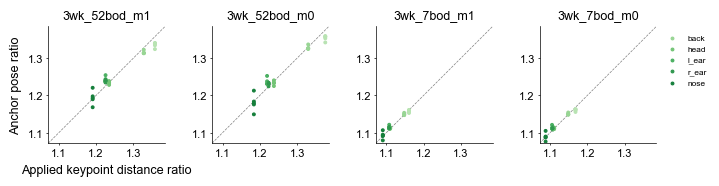

PosixPath('../../../data_explore/plots/notebook/small-blscale/achor-pose-ratios-vs-applied-bykp.pdf')

In [170]:
# applied vs anchor pose session-wise
rescale = True
sessions = dataset.sessions
parts = "01"
pairs = {
    s: re.sub(r"\d+bod", f"{ref_age}bod", s)
    for s in sessions
    if not f"{ref_age}bod" in s
}
# ---- get rescaled raw data and anchor poses, compute paired bone length ratios

_, raw, scan_align_meta = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
anchors = anchor_keypoints(  # shape (n_session, n_anchor, n_kpt, 3)
    params.morph,
    scan_align_meta,
    magnitudes=anchor_magnitudes(scan_dataset, params.morph, q=0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)

raw_bls = {
    s: np.concatenate(
        [_bone_lengths(raw.get_session(f"{s}.{part}"), arms) for part in parts]
    )
    for s in sessions
}
raw_ratios = {s: raw_bls[s] / raw_bls[pairs[s]] for s in pairs}

anchor_bls = {
    s: np.mean(
        [_bone_lengths(anchors[scan_dataset.session_id(f"{s}.{part}")], arms) for part in parts],
        axis = 0
    )
    for s in sessions
}
anchor_ratios = {s: anchor_bls[s] / anchor_bls[pairs[s]] for s in pairs}

# --- plot ratio in raw vs ratio in anchor poses
fig, ax, grid = viz.util.flat_grid(len(pairs), min(4, len(pairs)), ax_size=(1.85, 1.8))
min_, max_ = np.inf, -np.inf
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, arms.n_kpts - 1))
for i_p, s in enumerate(pairs):
    group = re.search(r"(\d+)bod", s).group(1)
    group_pal = {ref_age: ref_color, **{a: c for a, c in zip(tgt_ages, tgt_colors)}}
    anchor_pal = Colormap('husl')(np.linspace(0, 1, anchors.shape[1]))
    for i_a in range(anchors.shape[1]):
        ax[i_p].scatter(raw_ratios[s].mean(axis = 0), anchor_ratios[s][i_a], c = kp_colors, s=4)
    ax[i_p].set_title(s)

    xmin, xmax = ax[i_p].get_xlim()
    ymin, ymax = ax[i_p].get_ylim()
    min_, max_ = min(min_, xmin, ymin), max(max_, xmax, ymax)
for a in ax:
    a.set_xlim(min_, max_)
    a.set_ylim(min_, max_)
    a.plot([min_, max_], [min_, max_], color='.5', lw=0.5, ls='--', zorder=-1, )
    a.set_aspect(1.)
ax[0].set_ylabel("Anchor pose ratio")
ax[0].set_xlabel("Applied keypoint distance ratio")

# keypoint labels
nohip_names = [arms.keypoint_names[i] for i in range(arms.n_kpts) if arms.keypoint_names[i] != 'hips']
kp_artists = [
    ax[0].scatter([np.nan], [np.nan], color=kp_colors[i_kp], s=4, label=nohip_names[i_kp])
    for i_kp in range(1, arms.n_kpts - 1)
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0].get_legend_handles_labels()) if h in kp_artists])
grid[0, -1].legend(kp_handles, kp_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=6, frameon=False)

plotter.finalize(fig, 'achor-pose-ratios-vs-applied-bykp')

#### 3. Bone length distributions

Bone length distributions in observation and canonical spaces (with
appropriate scaling applied)

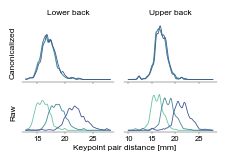

PosixPath('../../../data_explore/plots/notebook/small-blscale/bls-raw-vs-canon.pdf')

In [717]:
rescale = True


loback_ix = bone_names.index('hips-back') if 'hips-back' in bone_names else bone_names.index('back-hips')
hiback_ix = bone_names.index('back-shldr') if 'back-shldr' in bone_names else bone_names.index('shldr-back')
# lfpaw_ix = bone_names.index('lf_foot-shldr') if 'lf_foot-shldr' in bone_names else bone_names.index('shldr-lf_foot')
# rfpaw_ix = bone_names.index('rf_foot-shldr') if 'rf_foot-shldr' in bone_names else bone_names.index('shldr-rf_foot')

# ---- canonicalize, compute bone lengths of canonical and raw
canonicalized, raw, _ = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
bls_canon, bls_raw, _ = canonicalized_raw_bls(canonicalized, raw, dataset.sessions, parts = '01')

loback_canon = {k: v[:, loback_ix] for k, v in bls_canon.items()}
loback_raw = {k: v[:, loback_ix] for k, v in bls_raw.items()}
hiback_canon = {k: v[:, hiback_ix] for k, v in bls_canon.items()}
hiback_raw = {k: v[:, hiback_ix] for k, v in bls_raw.items()}
# flimb_canon = {k: v[:, [lfpaw_ix, rfpaw_ix]].mean(axis = 1) for k, v in bls_canon.items()}
# flimb_raw = {k: v[:, [lfpaw_ix, rfpaw_ix]].mean(axis = 1) for k, v in bls_raw.items()}


# ---- plot bone length distributions
fig, ax = plt.subplots(2, 2, figsize=(2.25, 1.5), sharex='col', sharey='row', height_ratios = [1.5, 1])
for group, color in zip([ref_age] + tgt_ages, [ref_color] + tgt_colors):

    loback_x = np.linspace(13, 28, 200)
    hiback_x = np.linspace(10, 28, 200)

    kw = dict(lw = 0.6, color = color, label = group)
    ax[0, 0].plot(*viz.util.kde(loback_canon[group], bw = 0.2, density=True, eval_x=loback_x), **kw)
    ax[0, 1].plot(*viz.util.kde(hiback_canon[group], bw = 0.2, density=True, eval_x=hiback_x), **kw)
    ax[1, 0].plot(*viz.util.kde(loback_raw[group], bw = 0.2, density=True, eval_x=loback_x), **kw)
    ax[1, 1].plot(*viz.util.kde(hiback_raw[group], bw = 0.2, density=True, eval_x=hiback_x), **kw)

for a in ax.ravel():
    a.set_yticks([])
    a.spines['left'].set_visible(False)

ax[0, 0].set_ylabel("Canonicalized")
ax[1, 0].set_ylabel("Raw")
# ax[1, 0].set_xlabel(" " * 25 + "Keypoint pair distance [mm]")
fig.text(0.55, 0.02, "Keypoint pair distance [mm]", ha='center', va='center')
ax[0, 0].set_title("Lower back")
# ax[0, 1].set_title("Forelimbs (mean)")
ax[0, 1].set_title("Upper back")

plotter.finalize(fig, 'bls-raw-vs-canon', despine=False)



#### 4. IQR of mean bone lengths

(only have 3 ages at the moment, so using full range)

[('lo back', 'back-hips'), ('hi back', 'shldr-back'), ('neck', 'head-shldr'), ('l_ear', 'l_ear-head'), ('r_ear', 'r_ear-head'), ('head', 'nose-head')]


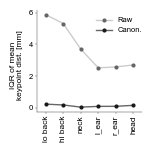

PosixPath('../../../data_explore/plots/notebook/small-blscale/mean-bl-iqrs.pdf')

In [715]:
rescale = True
short_names = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']
print(list(zip(short_names, bone_names)))
bone_order = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']

bone_ix_order = [short_names.index(n) for n in bone_order]
bone_name_order = [short_names[i] for i in bone_ix_order]

sessions = dataset.sessions
canonicalized, raw, _ = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = '01')
meanbls_canon = [[a[:, ix].mean() for a in bls_canon.values()] for ix in bone_ix_order]
meanbls_raw = [[a[:, ix].mean() for a in bls_raw.values()] for ix in bone_ix_order]

iqrs_canon = np.percentile(meanbls_canon, 100, axis = 1) - np.percentile(meanbls_canon, 0, axis = 1)
iqrs_raw = np.percentile(meanbls_raw, 100, axis = 1) - np.percentile(meanbls_raw, 0, axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
ax.plot(iqrs_raw, 'o-', color='.8', mfc='.4', mew=0, lw = 1, ms = 3, label='Raw')
ax.plot(iqrs_canon, 'o-', color='.4', mfc='.1', mew=0, lw = 1, ms = 3, label='Canon.')

ax.set_xticks(np.arange(len(bone_order)))
ax.set_xlim(-0.5, len(bone_order) - 0.5)
ax.set_xticklabels(bone_name_order, rotation = 90, fontsize = 6)
ax.set_ylabel("IQR of mean    \nkeypoint dist. [mm]    ")
viz.util.legend(ax, loc = 'upper left', frameon = False, bbox_to_anchor = (0.5, 1))
plotter.finalize(fig, 'mean-bl-iqrs')



#### 5. Relative growth rates

Regression coefficient of log-age vs average bone length ratios to other bones

[('lo back', 'back-hips'), ('hi back', 'shldr-back'), ('neck', 'head-shldr'), ('l_ear', 'l_ear-head'), ('r_ear', 'r_ear-head'), ('head', 'nose-head')]


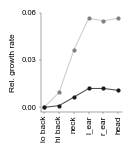

PosixPath('../../../data_explore/plots/notebook/small-blscale/rel-growth-rates.pdf')

In [714]:
rescale=True
short_names = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']
print(list(zip(short_names, bone_names)))
bone_order = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']
group_order = [ref_age] + tgt_ages


sessions = dataset.sessions
canoncalized, raw, _ = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = '01')


bone_ix_order = [short_names.index(n) for n in bone_order]
bone_name_order = [short_names[i] for i in bone_ix_order]

cov = lambda x, y: (x * y).mean(axis=-1) - x.mean(axis=-1) * y.mean(axis=-1)
coef = lambda a, b: cov(a, b) / cov(a, a)
coefs_raw = np.zeros([len(bone_order)] * 2)
coefs_canon = np.zeros([len(bone_order)] * 2)


for (r, r_ix), (c, c_ix) in iit.product(enumerate(bone_ix_order), enumerate(bone_ix_order)):
    if r == c:
        continue
    logage = np.log([int(g) for g in group_order])

    rto_canon = np.array([
        bls_canon[g][:, r_ix].mean() / bls_canon[g][:, c_ix].mean()
        for g in group_order
    ])
    coefs_canon[r, c] = coef(logage, rto_canon)

    rto_raw = np.array([
        bls_raw[g][:, r_ix].mean() / bls_raw[g][:, c_ix].mean()
        for g in group_order
    ])
    coefs_raw[r, c] = coef(logage, rto_raw)
    
fig, ax = plt.subplots(1, 1, figsize = (1.3, 1.5))
ax.plot(coefs_raw[0, :], '-', color = colors.subtle, lw = 0.75, label = 'Raw')
ax.plot(coefs_raw[0, :], 'o', color = '.5', ms = 2)
ax.plot(coefs_canon[0, :], '-', color = '.3', lw = 0.75, label = 'Canon.')
ax.plot(coefs_canon[0, :], 'o', color = colors.neutral, ms = 2)

ax.set_xticks(np.arange(len(bone_order)))
ax.set_xticklabels(bone_name_order, rotation = 90, fontsize = 6)
ax.set_ylabel("Rel. growth rate")
# viz.util.legend(ax, loc = 'upper left', fontsize = 6, frameon = False)
ax.set_yticks([0, 3e-2, 6e-2])
plotter.finalize(fig, 'rel-growth-rates')

#### 6. Framewise classification in raw and canonical pose space

In [695]:
rescale = True
sessions = dataset.sessions
canoncalized, raw, _ = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = '01', group_bodies=False)
groups = set(re.search(r"(\d+)bod", s).group(1) for s in sessions)
groups = {k: [s for s in sessions if re.search(r"(\d+)bod", s).group(1) == k] for k in groups}

print(bls_raw.keys())
print(groups)

r_scores, r_scores_null = pairwise_group_acc(bls_raw, groups, ref_age, tgt_ages)
r_indiv_across, r_indiv_null, r_indiv_within, r_indiv_self = pairwise_framewise_acc(bls_raw, groups)
r_indiv = r_indiv_across, r_indiv_within, r_indiv_self, r_indiv_null

c_scores, c_scores_null = pairwise_group_acc(bls_canon, groups, ref_age, tgt_ages)
c_indiv_across, c_indiv_null, c_indiv_within, c_indiv_self = pairwise_framewise_acc(bls_canon, groups)
c_indiv = c_indiv_across, c_indiv_within, c_indiv_self, c_indiv_null


dict_keys(['3wk_3bod_m0', '3wk_7bod_m1', '3wk_7bod_m0', '3wk_3bod_m1', '3wk_52bod_m0', '3wk_52bod_m1'])
{'7': ['3wk_7bod_m1', '3wk_7bod_m0'], '52': ['3wk_52bod_m1', '3wk_52bod_m0'], '3': ['3wk_3bod_m1', '3wk_3bod_m0']}


100%|██████████| 6/6 [00:00<00:00, 45.61it/s]


/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of f

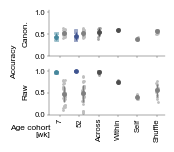

PosixPath('../../../data_explore/plots/notebook/small-blscale/bl_pairwise.pdf')

In [705]:


strip = lambda ax, keys, data, colors, offset, **kws: viz.util.grouped_stripplot(
    viz.util.expand_groups([np.array(data[a]) for a in keys], keys),
    x=np.arange(len(keys)) + offset,
    ax=ax,
    colors=dict(zip(keys, colors)),
    points_kw=dict(ms=1),
    errorbar_kw=dict(ms=2.5),
    **{
        **dict(
            xticks="",
            lighten_points=0.5,
            offset=False,
        ),
        **kws,
    },
)

fig, ax = plt.subplots(2, 1, figsize=(1.6, 1.5), sharex=True, sharey=True)

strip(ax[1], tgt_ages, r_scores, tgt_colors, -0.2)
strip(ax[1], tgt_ages, r_scores_null, ['.5', '.5'], 0.2)
strip(ax[1], range(4), r_indiv, ['.3', '.3', '.5', '.5'], 2)
strip(ax[0], tgt_ages, c_scores, tgt_colors, -0.2)
strip(ax[0], tgt_ages, c_scores_null, ['.5', '.5'], 0.2)
strip(ax[0], range(4), c_indiv, ['.3', '.3', '.5', '.5'], 2)

ax[1].set_xlim(-0.6, len(tgt_ages) + 3.4)
ax[1].set_ylim(0.0, 1.05)
ax[1].set_yticks([0.0, 0.5, 1.0])
ax[1].set_xticks(np.arange(len(tgt_ages) + 4))
ax[1].set_xticklabels(tgt_ages + ["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
ax[0].set_ylabel("Canon.")
ax[1].set_ylabel("Raw")
fig.text(0.23, 0.13, "Age cohort\n[wk]", ha = 'right', va = 'center', size = 6)
fig.text(0., 0.6, "Accuracy", ha='center', va='center', rotation=90)
# ax[1].set_xlabel("Age cohort [wk]")

plotter.finalize(fig, "bl_pairwise", save=True, despine=True, tight=True)

#### 7. Frame-wise keypoint distances in observation and canonicalized data

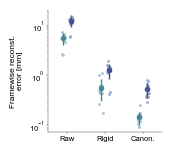

PosixPath('../../../data_explore/plots/notebook/small-blscale/reconst-error.pdf')

In [693]:
rescale = True
canonicalized, raw, _ = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
_, rigid, _ = canonicalized_and_raw(scan_dataset, params, dataset, rescale=False)
sessions = dataset.sessions
pairs = {s: re.sub(r"\d+bod", f"{ref_age}bod", s) for s in sessions if not f"{ref_age}bod" in s}
groups = set(re.search(r"(\d+)bod", s).group(1) for s in pairs)
groups = {k: [s for s in pairs if re.search(r"(\d+)bod", s).group(1) == k] for k in groups}
nohips = [i for i in range(arms.n_kpts) if arms.keypoint_names[i] != 'hips']

errs_raw = {
    s: np.concatenate([
        model_util.reconst_errs(
            raw.get_session(f"{pairs[s]}.{part}"),
            raw.get_session(f"{s}.{part}"),
            average=False,
        )
        for part in parts
    ]).mean(axis=0)
    for s in pairs
}
errs_canon = {
    s: np.concatenate([
        model_util.reconst_errs(
            canonicalized.get_session(f"{pairs[s]}.{part}"),
            canonicalized.get_session(f"{s}.{part}"),
            average=False,
        )
        for part in parts
    ]).mean(axis=0)
    for s in pairs
}
errs_rigid = {
    s: np.concatenate([
        model_util.reconst_errs(
            rigid.get_session(f"{pairs[s]}.{part}"),
            rigid.get_session(f"{s}.{part}"),
            average=False,
        )
        for part in parts
    ]).mean(axis=0)
    for s in pairs
}



fig, ax = plt.subplots(1, 1, figsize=(1.7, 1.5))
viz.util.grouped_stripplot(
    {g: [np.array([errs_raw[s][nohips] for s in l])] for g, l in groups.items()},
    ax = ax,
    colors = {g: c for g, c in zip(tgt_ages, tgt_colors)},
    group_order=tgt_ages,
    lighten_points=0.5,
    points_kw=dict(ms=1),
)
viz.util.grouped_stripplot(
    {g: [np.array([errs_rigid[s][nohips] for s in l])] for g, l in groups.items()},
    ax = ax,
    x = [1],
    colors = {g: c for g, c in zip(tgt_ages, tgt_colors)},
    group_order=tgt_ages,
    lighten_points=0.5,
    points_kw=dict(ms=1),
)
viz.util.grouped_stripplot(
    {g: [np.array([errs_canon[s][nohips] for s in l])] for g, l in groups.items()},
    ax = ax,
    x = [2],
    colors = {g: c for g, c in zip(tgt_ages, tgt_colors)},
    group_order=tgt_ages,
    lighten_points=0.5,
    points_kw=dict(ms=1),
)
ax.set_xticks([0, 1, 2])
ax.set_xlim(-0.5, 2.5)
ax.set_xticklabels(["Raw", "Rigid", "Canon."])
ax.set_yscale('log')
ax.set_ylabel("Framewise reconst.\nerror [mm]")
plotter.finalize(fig, 'reconst-error')

#### (8-0.1 Naive GMMs)

Fit to each individual, all cohorts, without bone length scaling or any
size normalization.

##### Dataset loading and calibration

In [8]:
def full_ontogeny_data(data_dir, ref_session=None):
    _sources = dict(map(lambda x: (_name_func(str(x)),) * 2, data_dir.glob(f"*.npy")))
    ont_keypoints, _ = loader.from_sources_dict(
        data_dir,
        _sources,
        extension='.npy',
        name_func=_name_func,
    )
    names, parents, _, _ = raw_data_armature_meta()

    if ref_session is None:
        ref_session = list(ont_keypoints.keys())[0]

    project_config_kws = {
        "session_names": ont_keypoints.keys(),
        "bodies": {s: f'b-{s}' for s in ont_keypoints},
        "ref_session": ref_session,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, ont_keypoints

# Shouldn't matter what the reference session is: not even calibrating a morph
# or pose model
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")
ont_project_config_kws, ont_keypoints = full_ontogeny_data(data_dir, "3wk_m0")


Loading keypoints: 100%|███████████████| 48/48 [00:00<00:00, 292.71it/s]


In [9]:
ont_project_dir = Path('../projects/blscale-test/full-ont-gmm')
ont_project_dir.mkdir(exist_ok = True)
ont_project = Project(ont_project_dir)

plot_dir = ont_project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')

In [13]:
loaders.arrays.setup_project_config(
    ont_project.main_config(),
    feature_type="pcs",
    alignment_type="sagittal",
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=1000,
    **ont_project_config_kws,
)

setup.setup_base_model_config(
    ont_project.main_config(), ont_project.base_model_config()
)

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(ont_project.main_config())
ont_dataset = loaders.arrays.from_arrays(ont_keypoints, cfg["dataset"])
cfg["features"]["calibration"]["tgt_variance"] = 0.98
cfg['alignment']['rescale'] = False

_aligned, cfg = alignment.sagittal.calibrate(
    ont_dataset, cfg, origin="hips", anterior="head", 
)

cfg = features.pcs.calibrate(_aligned, cfg)
config.save_project_config(ont_project.main_config(), cfg, write_calib=True)

# --- calibration: EM (no morph or pose model)
cfg = config.load_model_config(ont_project.base_model_config())
cfg = em.calibrate_base_model(ont_dataset, cfg)
config.save_model_config(ont_project.base_model_config(), cfg, write_calib=True)

ont_scan_cfg, ont_model_cfg = scans.setup_scan_config(ont_project, "split-scan", {
    "fit.em.n_steps": [np.nan],  # this is never meant to be run, just to split data
})

cfg = config.load_model_config(ont_project.base_model_config())
ont_arms = Armature.from_config(cfg["dataset"])
ont_dataset = loaders.arrays.from_arrays(ont_keypoints, cfg["dataset"])
ont_dataset_versions, _ = methods.prepare_dataset(ont_dataset, cfg, all_versions=True)
ont_scan_dataset, split_meta, align_meta = scans.prepare_scan_dataset(
    ont_dataset, ont_project, "split-scan", return_session_inv=True
)

INFO:root:Reducing dataset size for PCA: 48000 to 10000.


##### GMM fitting

In [14]:
sessions = ont_dataset.sessions
n_components = 5
components = {}
weights = {}

for s in sessions:
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type="full",
        max_iter=1000,
        random_state=0,
    ).fit(ont_dataset_versions["reduced"].get_session(s))
    components[s] = gmm.means_
    for t in split_meta[1][s]:
        weights[t] = gmm.predict_proba(ont_scan_dataset.get_session(t)).mean(axis=0)

#### 8. Components and weights for example session halves

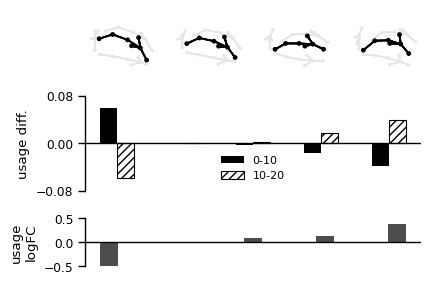

PosixPath('../projects/blscale-test/full-ont-gmm/plots/split-component-usages.pdf')

In [20]:
ex_session = '3wk_m0'
ex_weights = np.array([weights[f"{ex_session}.{part}"] for part in '01'])
comp_order = np.argsort(ex_weights[1] - ex_weights[0])
selected_comps = [0, 1, 3, 4]
inflated_comps = features.inflate(components[ex_session], cfg["features"])
ordered_avg = np.mean(ex_weights[:, comp_order], axis = 0)
ordered_logfc = np.log(ex_weights[1, comp_order] / ex_weights[0, comp_order])

# 3d plotting with shadow
kws = lambda c, ps, ls: dict(
    armature = ont_arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * ont_arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(x[:, 2].min() + z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(x[:, 1].max() + y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(x[:, 0].min() + xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, lsm = 1, shad=True: [
    plot_mouse_3d(f, a, **kws(c, sm * 40, 3 * lsm))] + ([
    plot_mouse_3d(dropz(f, -5), a, **kws('.9', sm * 20, 2 * lsm)),
    plot_mouse_3d(dropy(f, 10), a, **kws('.9', sm * 20, 2 * lsm)),
    plot_mouse_3d(dropx(f, -5), a, **kws('.9', sm * 20, 2 * lsm)),
] if shad else [])

# ---- component means
n_select = len(selected_comps)
fig = plt.figure(figsize = (1.1 * (n_select), 1.1 * 3))
gs_top_row = plt.GridSpec(3, n_select, height_ratios=[3, 2, 1], hspace=0)
gs_main = plt.GridSpec(3, 1, height_ratios=[2, 2, 1])

top_row = []
for i in range(n_select):
    ax = fig.add_subplot(gs_top_row[0, i], projection='3d')
    top_row.append(ax)
    if i > 0:
        ax.sharey(top_row[0])
    frame = inflated_comps[comp_order[selected_comps[i]]]
    plotdrop(frame, ax, 'k', sm = 0.3, lsm = 0.6)

ax = fig.add_subplot(gs_main[1])
bar_width = 0.25
ofs = [-bar_width/2, bar_width/2]
for i, (fill, hatch, label) in enumerate(zip([True, False], [None, '////'], ['0-10', '10-20'])):
    ax.bar(
        np.arange(n_components) + ofs[i],
        width = bar_width,
        color = 'k',
        fill = fill,
        hatch = hatch,
        **viz.util.stem_bar(
            ex_weights[i, comp_order] - ordered_avg,
            center = 0),
        label = label,
    )
viz.util.round_limits(ax, 0.5, x = False)
ax.set_yticks([ax.get_ylim()[0], 0, ax.get_ylim()[1]])
ax.set_xticks([])
ax.axhline(0, color = 'k', lw = 1)
sns.despine(ax = ax, bottom = True)
ax.set_ylabel("usage diff.")
viz.util.legend(ax, loc = 'lower center', bbox_to_anchor = None, fontsize=8)

ax = fig.add_subplot(gs_main[2])
# ax.bar(
#     np.arange(n_components) - viz.util.get_offsets(2, i),
#     ordered_avg,
#     width = bar_width,
#     color = '.3',
#     bottom=0,
# )
ax.bar(
    np.arange(n_components) - viz.util.get_offsets(2, i),
    ordered_logfc,
    width = bar_width,
    color = '.3',
    bottom=0,
)
ax.set_xticks([])
# ax.set_ylabel("total\nusage")
ax.set_ylabel("usage\nlogFC")
ax.axhline(0, color = 'k', lw = 1)
vrng = max(abs(ax.get_ylim()[0]), ax.get_ylim()[1])
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([-0.5, 0, 0.5])
sns.despine(ax = ax, bottom=True, trim = True)

plotter.finalize(fig, 'split-component-usages', despine = False)

#### 9. Difference in component weights for between session halves, all sessions

(relies on variables defined in 8.)

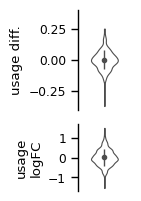

PosixPath('../projects/blscale-test/full-ont-gmm/plots/split-component-usages-all.pdf')

In [17]:
sessions = list(ont_dataset.sessions)
ex_ix = ont_dataset.session_id(ex_session)
weight_diffs = {s: weights[f"{s}.1"] - weights[f"{s}.0"] for s in sessions}
weight_logfc = {s: np.log(weights[f"{s}.1"] / weights[f"{s}.0"]) for s in sessions}

fig, ax = plt.subplots(2, 1, figsize=(1.5, 2.1), sharex=True, height_ratios=[3, 2])
kws = dict(
    bw=0.005,
    offset=False,
    jitter=False,
    colors = '.3',
    lighten_points=0.7,
    lim_buffer=0.3,
    points_kw=dict(ms=1),
)
violin_kw = dict(
    offset = False,
    jitter = False,
    colors = '.3',
    points=False,
    lim_buffer=0.3,
    fill_kw=dict(zorder=-2),
)
# viz.util.grouped_violin_points(
#     [[np.concatenate(list(weight_diffs.values()))]],
#     ax = ax[0], **kws
# )
viz.util.grouped_violins(
    [[np.concatenate(list(weight_diffs.values()))]],
    ax = ax[0],
    bw = 0.02,
    **violin_kw
)
# viz.util.grouped_violin_points(
#     [[np.concatenate(list(weight_logfc.values()))]],
#     ax = ax[1], **kws
# )
viz.util.grouped_violins(
    [[np.concatenate(list(weight_logfc.values()))]],
    ax = ax[1],
    bw = 0.1,
    **violin_kw
)
ax[1].set_xticks([])
vrng = max(abs(ax[0].get_ylim()[0]), ax[0].get_ylim()[1])
ax[0].set_ylim(-vrng, vrng)
vnrg = max(abs(ax[1].get_ylim()[0]), ax[1].get_ylim()[1])
ax[1].set_ylim(-vnrg, vnrg)
ax[0].set_ylabel("usage diff.")
ax[1].set_ylabel("usage\nlogFC")
for a in ax:
    sns.despine(ax = a, bottom = True)
plotter.finalize(fig, 'split-component-usages-all', despine = False)

#### (10-0.1 Naive models on bone-scaled data) 

In [157]:
def naive_model_params(ref_pc, upds_best, ref_center, alt_center, ref_body_id):
    return LRAParams(dict(
        n_bodies = len(alt_center) + 1,
        n_feats = ref_pc.shape[0],
        ref_body = ref_body_id,
        n_dims = ref_pc.shape[1],
        prior_mode = 'distance',
        # --- hyperparams
        upd_var_modes = 1.,
        upd_var_ofs = 1.,
        dist_var = 1.,
        modes = jnp.array(ref_pc),
        offset = jnp.array(ref_center),
        # --- trainable params
        _mode_updates = jnp.array(np.insert(upds_best, ref_body_id, 0, axis = 0)),
        _offset_updates = jnp.array(np.insert(alt_center - ref_center[None], ref_body_id, 0, axis = 0)),
    ))

def naive_model_anchors(
    canonicalized_dict,
    session_params,
    config,
    magnitudes=None
):
    """Compute anchor poses for a collection of naive models fit to session
    half pairs.
    
    Parameters
    ----------
    canonicalized_dict : dict
        Dictionary of canonicalized keypoints, with keys <session>.<part>
    session_params : dict
        Dictionary of session morph parameters, with keys <session>
    config : dict
        Configuration used to inflate from features to keypoints
    
    Returns
    -------
    anchors : dict[str, array (2,n_anchor, n_kpt, 3)]
        Dictionary of anchor poses, with keys <session>, containing anchor poses
        for each parameter set.
    """
    if magnitudes is None:
        magnitudes = {
            s: anchor_magnitudes(jnp.concatenate([
                canonicalized_dict[f"{s}.0"],
                canonicalized_dict[f"{s}.1"],
            ]), session_params[s], q=0.1)
            for s in session_params
        }
    if not isinstance(magnitudes, dict):
        magnitudes = {s: magnitudes for s in session_params}
    return {
        s: anchor_keypoints(
            session_params[s],
            {},
            magnitudes=magnitudes[s],
            config=config,
        )
        for s in session_params
    }


In [158]:
# --- fit naive models
sessions = list(dataset.sessions)
print(sessions)
naive_transformed = {}
naive_canonicalized = {}
naive_params = {}
naive_anchors = {}
for s in tqdm.tqdm(sessions):
    ref_pc, upds_best, ref_center, alt_center, = pca.fit_covariance_alignment(
        scan_dataset.get_session(f"{s}.0"),
        scan_dataset.get_session(f"{s}.1")[None],
        n_upd = 4,
        alpha = 1e-3,
        progress=False
    )
    alt_centered = scan_dataset.get_session(f"{s}.1") - alt_center
    naive_transformed[s] = alt_centered @ pca.covariance_alignment_transform(ref_pc, upds_best)[0] #+ ref_center
    naive_canonicalized[f"{s}.0" ] = scan_dataset.get_session(f"{s}.0")
    naive_canonicalized[f"{s}.1" ] = naive_transformed[s]
    naive_params[s] = naive_model_params(ref_pc, upds_best, ref_center, alt_center, 0)

['3wk_52bod_m1', '3wk_52bod_m0', '3wk_3bod_m1', '3wk_3bod_m0', '3wk_7bod_m1', '3wk_7bod_m0']


100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


#### 10. Naive v. Informed model anchor poses in first and second half

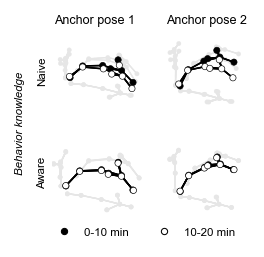

PosixPath('../../../data_explore/plots/notebook/small-blscale/anchor-pose-naive.pdf')

In [692]:
naive_anchors = naive_model_anchors(
    naive_canonicalized,
    naive_params,
    cfg,
)

smart_anchors = anchor_keypoints(
    params.morph,
    {},
    magnitudes=anchor_magnitudes(scan_dataset, params.morph, q = 0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)


kws = lambda fc, ec, ps, ls, label=None: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([fc] * arms.n_kpts),
    line_colors = np.array([ec] * arms.n_kpts),
    point_size = ps,
    line_size = ls,
    label=label,
    point_kws = {'edgecolor': np.array([ec]*arms.n_kpts), 'linewidths': np.array([ls / 2]*arms.n_kpts)},
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, fc, ec, sm=1, lsm=1, shad=True, dropax=None, label=None: [
    plot_mouse_3d(f, a, **kws(fc, ec, sm * 15, 1.5 * lsm, label))
    ] + [
    dropax := dropax if dropax is not None else a,
    ] + ([
    plot_mouse_3d(dropz(f, -5), dropax, **kws('.9', '.9', sm * 7, 1 * lsm)),
    plot_mouse_3d(dropy(f, 15), dropax, **kws('.9', '.9', sm * 7, 1 * lsm)),
    plot_mouse_3d(dropx(f, -5), dropax, **kws('.9', '.9', sm * 7, 1 * lsm)),
] if shad else [])

nplot = 2
fig = plt.figure(figsize=(0.75 * nplot, 1.5), dpi=150)
gs = plt.GridSpec(2, nplot)
row0_shad = np.array([fig.add_subplot(gs[0, i], projection='3d') for i in range(nplot)])
row0_back = np.array([fig.add_subplot(gs[0, i], projection='3d') for i in range(nplot)])
row0_frnt = np.array([fig.add_subplot(gs[0, i], projection='3d') for i in range(nplot)])
row1_shad = np.array([fig.add_subplot(gs[1, i], projection='3d') for i in range(nplot)])
row1_back = np.array([fig.add_subplot(gs[1, i], projection='3d') for i in range(nplot)])
row1_frnt = np.array([fig.add_subplot(gs[1, i], projection='3d') for i in range(nplot)])

ex_sess = f'{ref_age}wk_{ref_age}bod_m1'
ex_part0_id = scan_dataset.session_id(f"{ex_sess}.0")
ex_part1_id = scan_dataset.session_id(f"{ex_sess}.1")
for i in range(len(row0_back)):
    for axs in [[row0_back[i], row0_frnt[i], row0_shad[i]], [row1_back[i], row1_frnt[i], row1_shad[i]]]:
        for a in axs[1:]:
            a.sharex(axs[0])
            a.sharey(axs[0])
            a.sharez(axs[0])
for a in iit.chain(row0_back, row0_frnt, row0_shad, row1_back, row1_frnt, row1_shad):
    a.set_facecolor((0, 0, 0, 0))

for i in range(len(row0_back)):
    # naive anchors anchors
    plotdrop(naive_anchors[ex_sess][0, i], row0_back[i], 'k', 'k', 0.6, 0.4, dropax=row0_shad[i])
    plotdrop(naive_anchors[ex_sess][1, i], row0_frnt[i], 'w', 'k', 0.6, 0.4, dropax=row0_shad[i])
    # smart anchors
    plotdrop(smart_anchors[ex_part0_id, i], row1_back[i], 'k', 'k', 0.6, 0.4, dropax=row1_shad[i])
    plotdrop(smart_anchors[ex_part1_id, i], row1_frnt[i], 'w', 'k', 0.6, 0.4, dropax=row1_shad[i])

row1_frnt[0].plot([np.nan], [np.nan], [np.nan], 'o', mfc='k', mec='k', mew=0.5, ms = 3, label='0-10 min')
row1_frnt[0].plot([np.nan], [np.nan], [np.nan], 'o', mfc='w', mec='k', mew=0.5, ms = 3, label='10-20 min')

fig.text(0.25, 1, 'Anchor pose 1', ha='center', va='top', size=6)
fig.text(0.75, 1, 'Anchor pose 2', ha='center', va='top', size=6)
fig.text(0.02, 0.75, "Naive", ha = 'center', va = 'center', rotation=90, size=5.5)
fig.text(0.02, 0.3, "Aware", ha = 'center', va = 'center', rotation=90, size=5.5)
fig.text(-0.08, 0.52, "Behavior knowledge", ha = 'center', va = 'center', rotation=90, size=5.5, fontstyle='italic')

fig.tight_layout()
viz.util.legend(row1_frnt[0], loc = 'upper center', bbox_to_anchor = (1, 0.1), ncol=2)

plotter.finalize(fig, 'anchor-pose-naive', tight=False)

#### 11. Morphology distance first to second half, naive model

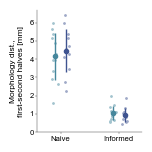

PosixPath('../../../data_explore/plots/notebook/small-blscale/reconst-error-naive-vs-informed.pdf')

In [691]:
naive_inflated = {s: features.inflate(naive_transformed[s], cfg["features"]) for s in sessions}
scan_inflated = features.inflate(scan_dataset, cfg["features"])
canonicalized, _, _ = canonicalized_and_raw(scan_dataset, params, dataset, False)

# distance from canonicalized to original - naive model
errs_naive = {
    s: np.mean(model_util.reconst_errs(
        naive_inflated[s],
        scan_inflated.get_session(f"{s}.1"),
        average=False,
    ), axis=0)
    for s in sessions
}
# distance from canonicalized to original - informed model
errs_canon = {
    s: np.mean(model_util.reconst_errs(
        canonicalized.get_session(f"{s}.1"),
        scan_inflated.get_session(f"{s}.1"),
        average=False,
    ), axis=0)
    for s in sessions
}

# group all session s in `scan_inflated` by age (session name '..._<age>bod_...')
groups = set(re.search(r"(\d+)bod", s).group(1) for s in scan_inflated.sessions)
groups = {k: [s for s in pairs if re.search(r"(\d+)bod", s).group(1) == k] for k in groups}
nohips = np.array([i for i in range(arms.n_kpts) if arms.keypoint_names[i] != 'hips'])

# stripplot of `errs_naive` and `errs_canon` by age group, omitting 'hips' keypoint
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
viz.util.grouped_stripplot(
    {g: [np.array([errs_naive[s][nohips] for s in l])] for g, l in groups.items()},
    ax = ax,
    x = [0],
    colors = {g: c for g, c in zip(tgt_ages, tgt_colors)},
    group_order=tgt_ages,
    lighten_points=0.5,
    points_kw=dict(ms=1),
)
viz.util.grouped_stripplot(
    {g: [np.array([errs_canon[s][nohips] for s in l])] for g, l in groups.items()},
    ax = ax,
    x = [1],
    colors = {g: c for g, c in zip(tgt_ages, tgt_colors)},
    group_order=tgt_ages,
    lighten_points=0.5,
    points_kw=dict(ms=1),
)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Naive", "Informed"])
ax.set_ylim(0, None)
ax.set_xlim(-0.4, 1.4)
ax.set_ylabel("Morphology dist.,\nfirst-second halves [mm]")
plotter.finalize(fig, 'reconst-error-naive-vs-informed')


#### 12. Naive model anchor poses do not faithfully represent bone lengths

(de-prioritizing this plot: it's fairly obvious from showing the anchor poses
that this is not the main problem; it's the joint angles for which there's no
obvious ground truth to show that our model learns)

In [207]:
rescale = True
sessions = dataset.sessions
parts = "01"
pairs = {
    s: re.sub(r"\d+bod", f"{ref_age}bod", s)
    for s in sessions
    if not f"{ref_age}bod" in s
}

# ---- get rescaled raw data and anchor poses, compute paired bone length ratios

_, raw, scan_align_meta = canonicalized_and_raw(scan_dataset, params, dataset, rescale=rescale, scale_to=scale_to)
naive_anchors = naive_model_anchors(
    naive_canonicalized,
    naive_params,
    cfg,
    magnitudes=None,
)

raw_bls = {
    s: np.concatenate(
        [_bone_lengths(raw.get_session(f"{s}.{part}"), arms) for part in parts]
    )
    for s in sessions
}
raw_ratios = {s: raw_bls[s] / raw_bls[pairs[s]] for s in pairs}

# anchor_bls = {
#     s: np.mean(
#         [_bone_lengths(anchors[scan_dataset.session_id(f"{s}.{part}")], arms) for part in parts],
#         axis = 0
#     )
#     for s in sessions
# }
# anchor_ratios = {s: anchor_bls[s] / anchor_bls[pairs[s]] for s in pairs}

# --- plot ratio in raw vs ratio in anchor poses
# fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
# for s in pairs:
#     group = re.search(r"(\d+)bod", s).group(1)
#     group_pal = {ref_age: ref_color, **{a: c for a, c in zip(tgt_ages, tgt_colors)}}
#     anchor_pal = Colormap('husl')(np.linspace(0, 1, anchors.shape[1]))
#     for i_a in range(anchors.shape[1]):
#         ax.scatter(raw_ratios[s].mean(axis = 0), anchor_ratios[s][i_a], color=group_pal[group], s=4, label=group)

# xmin, xmax = ax.get_xlim()
# ymin, ymax = ax.get_ylim()
# min_, max_ = min(xmin, ymin), max(xmax, ymax)
# ax.set_xlim(min_, max_)
# ax.set_ylim(min_, max_)
# ax.plot([min_, max_], [min_, max_], color='.5', lw=0.5, ls='--', zorder=-1, )
# ax.set_aspect(1.)
# ax.set_ylabel("Anchor pose ratio")
# ax.set_xlabel("Applied keypoint\ndistance ratio")
# hl = zip(*sorted(zip(*viz.util.unique_handles(ax)), key=lambda x: int(x[1])))
# leg = viz.util.legend(ax, hl, loc='lower left', bbox_to_anchor=(0.8, 0.1), frameon=True, title='Sim. cohort')
# leg._legend_box.align = 'left'
# leg._legend_box.fontSize = 8
# for h in leg.legend_handles:
#     h.set_sizes([10])

# plotter.finalize(fig, 'anchor-poses-bls-vs-applied')

#### 13. Component weights for two example ages during first and second half


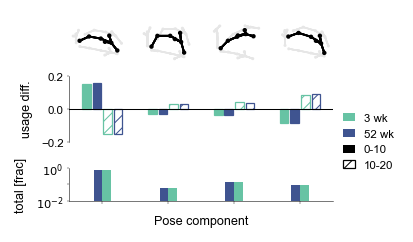

PosixPath('../../../data_explore/plots/notebook/small-blscale/split-component-usages-joint.pdf')

In [689]:
ex0 = f'{ref_age}wk_{ref_age}bod_m0'
ex1 = f'{ref_age}wk_{tgt_age}bod_m0'
ex_weights = np.array([
    [params.pose.subj_weights[scan_dataset.session_id(f"{ex0}.{part}")] for part in '01'],
    [params.pose.subj_weights[scan_dataset.session_id(f"{ex1}.{part}")] for part in '01'],    
])
comp_order = np.argsort(ex_weights.mean(axis=0)[1] - ex_weights.mean(axis=0)[0])
selected_comps = [0, 1, 2, 3]
inflated_comps = features.inflate(params.pose.means, cfg["features"])
ordered_avg = np.mean(ex_weights[:, :, comp_order], axis = (0, 1))
ordered_logfc = np.log(ex_weights[:, 1, comp_order] / ex_weights[:, 0, comp_order])

# 3d plotting with shadow
kws = lambda c, ps, ls: dict(
    armature = ont_arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * ont_arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(x[:, 2].min() + z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(x[:, 1].max() + y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(x[:, 0].min() + xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, lsm = 1, shad=True: [
    plot_mouse_3d(f, a, **kws(c, sm * 15, 1.5 * lsm))] + ([
    plot_mouse_3d(dropz(f, -5), a, **kws('.9', sm * 7, 1 * lsm)),
    plot_mouse_3d(dropy(f, 10), a, **kws('.9', sm * 7, 1 * lsm)),
    plot_mouse_3d(dropx(f, -5), a, **kws('.9', sm * 7, 1 * lsm)),
] if shad else [])

# ---- component means
n_select = len(selected_comps)
fig = plt.figure(figsize = (0.5 * (n_select) + 0.3, 1.8), dpi = 150)
gs_top_row = plt.GridSpec(3, n_select, height_ratios=[3, 2, 0.6], hspace=0)
gs_main = plt.GridSpec(3, 1, height_ratios=[2, 2, 1])

top_row = []
for i in range(n_select):
    ax = fig.add_subplot(gs_top_row[0, i], projection='3d')
    top_row.append(ax)
    if i > 0:
        ax.sharey(top_row[0])
    frame = inflated_comps[comp_order[selected_comps[i]]]
    plotdrop(frame, ax, 'k', sm = 0.3, lsm = 0.6)

# ---- component usages during each session half
ax = fig.add_subplot(gs_main[1])
bar_width = 0.13
buff = 0.16
ofs = [-3*buff/2, -buff/2, buff/2, 3*buff/2]
for bar_i, ((subj_i, part_i), fill, hatch, color) in enumerate(zip(
    [(0, 0), (1, 0), (0, 1), (1, 1)],
        [True, True, False, False],
        [None, None, '////', '////'],
        [ref_color, tgt_color, ref_color, tgt_color])):
    ax.bar(
        np.arange(params.pose.n_components) + ofs[bar_i],
        width = bar_width,
        color = color,
        edgecolor = color,
        fill = fill,
        hatch = hatch,
        linewidth = 0.6,
        **viz.util.stem_bar(
            ex_weights[subj_i, part_i, comp_order] - ordered_avg,
            center = 0),
    )
# labels
ax.bar([0], [np.nan], color = ref_color, label = f"{ref_age} wk")
ax.bar([0], [np.nan], color = tgt_color, label = f"{tgt_age} wk")
ax.bar([0], [np.nan], color = 'k', label = "0-10")
ax.bar([0], [np.nan], color = 'k', fill=False, hatch = '////', label = "10-20", lw = 0.6)
# limits, ticks, (legend at very end after tight layout)
viz.util.round_limits(ax, 0.5, x = False)
ax.set_yticks([ax.get_ylim()[0], 0, ax.get_ylim()[1]])
ax.set_xticks([])
ax.set_xlim(-0.5, params.pose.n_components - 1 + 0.5)
ax.axhline(0, color = 'k', lw = 0.5)
sns.despine(ax = ax, bottom = True)
ax.set_ylabel("usage diff.")
ax_middle = ax

ax = fig.add_subplot(gs_main[2])
for i, (logfc, color) in enumerate(zip(ordered_logfc, [ref_color, tgt_color])):
    ax.bar(
        np.arange(params.pose.n_components) - bar_width * (i - 0.5),
        ex_weights[i, :, comp_order].mean(axis = 1),
        width = bar_width,
        color = color,
        bottom=0,
    )
ax.set_xticks(np.arange(params.pose.n_components))
ax.set_xticklabels([""] * params.pose.n_components)
ax.set_xlim(-0.5, params.pose.n_components - 1 + 0.5)
ax.set_ylim(1e-2, 1)
ax.set_ylabel("total [frac]")
ax.set_yscale('log')
ax.minorticks_off()
ax.set_yticks([1e-2, 1e-1, 1])
ax.set_yticklabels(["$10^{-2}$", "", "$10^0$"])
ax.set_xlabel("Pose component")
sns.despine(ax = ax)

plt.tight_layout()
viz.util.legend(ax_middle, loc = 'center left', bbox_to_anchor = (1., 0.), handlelength=1.)
plotter.finalize(fig, 'split-component-usages-joint', despine = False, tight=False)

#### (13-0.1) Fit pose models across age without morphs

In [368]:
# as an approximation to a GMM with shared components but separated weights fit
# a single GMM to the raw data, then measure weights of each session in
# individually according to the jointly-fit components

# -- fit GMM to total raw data
gmm = GaussianMixture(
    n_components=params.pose.n_components,
    covariance_type="full",
    max_iter=1000,
    random_state=0,
).fit(scan_dataset._data)

# -- measure weights
nomorph_weights = np.zeros([scan_dataset.n_sessions, params.pose.n_components])
for i in range(scan_dataset.n_sessions):
    nomorph_weights[i] = gmm.predict_proba(scan_dataset.get_session(i)).mean(axis=0)

# -- measure control: weight JSDs with noise added to keypoints
# control GMMs
control_jsd_raw = np.zeros([scan_dataset.n_sessions, 100])
rng = np.random.default_rng(1029)
for j in range(scan_dataset.n_sessions):
    s = scan_dataset.get_session(j)
    weights0 = gmm.predict_proba(s).mean(axis=0)
    for i in range((control_jsd_raw.shape[1])):
        data1 = features.inflate(s, cfg["features"])
        data1 += rng.normal(0, 1, data1.shape)
        data1 = features.reduce_to_features(data1, cfg["features"])
        weights1 = gmm.predict_proba(data1).mean(axis=0)
        control_jsd_raw[j, i] = jensenshannon(weights0, weights1, base=2) ** 2

#### 13. Component distributions are the same across simulated morph

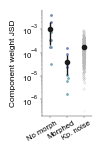

PosixPath('../../../data_explore/plots/notebook/small-blscale/component-usage-jsd-to-reference.pdf')

In [694]:
sessions = dataset.sessions
pairs = {
    s: re.sub(r"\d+bod", f"{ref_age}bod", s)
    for s in sessions
    if not f"{ref_age}bod" in s
}

# component_weight_JSD(pair[ref.0], pair[tgt.0]) (same for .1)
weight_jsd = {
    s: [
        jensenshannon(
            params.pose.subj_weights[scan_dataset.session_id(f"{s}.{part}"), comp_order],
            params.pose.subj_weights[scan_dataset.session_id(f"{pairs[s]}.{part}"), comp_order],
            base=2
        ) ** 2
        for part in "01"
    ]
    for s in pairs
}
nomorph_jsd = {
    s: [
        jensenshannon(
            nomorph_weights[scan_dataset.session_id(f"{s}.{part}"), comp_order],
            nomorph_weights[scan_dataset.session_id(f"{pairs[s]}.{part}"), comp_order],
            base=2
        ) ** 2
        for part in "01"
    ]
    for s in pairs
}
control_jsd = {
    s: [
        control_jsd_raw[scan_dataset.session_id(f"{s}.{part}")]
        for part in "01"
    ]
    for s in pairs
}

# --- stripplot of `weight_jsd`, colored by age, one error bar
groups = set(re.search(r"(\d+)bod", s).group(1) for s in weight_jsd)
groups = {k: [s for s in pairs if re.search(r"(\d+)bod", s).group(1) == k] for k in groups}

fig, ax = plt.subplots(1, 1, figsize=(1., 1.5))

for x, j, c, ms in zip([0, 1, 2], [nomorph_jsd, weight_jsd, control_jsd], [None, None, '.6'], [1, 1, 0.1]):
    viz.util.grouped_stripplot(
        {g: [np.array([j[s] for s in l]).ravel()] for g, l in groups.items()},
        x = [x],
        ax = ax,
        offset=False,
        colors = {g: c for g, c in zip(tgt_ages, tgt_colors)} if c is None else c,
        group_order=tgt_ages,
        lighten_points=0.3,
        points_kw=dict(alpha=1, ms = ms),
        errorbar=False
    )
    viz.util.grouped_stripplot(
        [np.concatenate([[j[s] for s in l] for l in groups.values()]).ravel()],
        x = [x],
        ax = ax,
        offset=False,
        colors = '.1',
        points=False,
        errorbar=True,
        error=lambda x: viz.util.ci(x, np.nanmean, 0.95), 
    )

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["No morph", "Morphed", 'Kp. noise'], rotation=30, rotation_mode='anchor', ha='right')

from matplotlib.transforms import ScaledTranslation
dx, dy = 5, 0
offset = ScaledTranslation(dx / fig.dpi, dy / fig.dpi, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

ax.set_xlim(-0.5, 2.5)
ax.set_ylabel("Component weight JSD")
ax.set_yscale('log')
plotter.finalize(fig, 'component-usage-jsd-to-reference')


